In [1]:
!pip install pywavelets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 24.9 MB/s eta 0:00:00


In [6]:
from google.colab import drive
drive.mount('/content/Drive')

data = pd.read_csv("/content/Drive/MyDrive/emotions.csv")
print(data.info())

data.head()

Mounted at /content/Drive
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2132 entries, 0 to 2131
Columns: 2549 entries, # mean_0_a to label
dtypes: float64(2548), object(1)
memory usage: 41.5+ MB
None


,# mean_0_a,mean_1_a,mean_2_a,mean_3_a,mean_4_a,mean_d_0_a,mean_d_1_a,mean_d_2_a,mean_d_3_a,mean_d_4_a,...,fft_741_b,fft_742_b,fft_743_b,fft_744_b,fft_745_b,fft_746_b,fft_747_b,fft_748_b,fft_749_b,label
0,4.62,30.3,-356.0,15.6,26.3,1.070,0.411,-15.70,2.06,3.15,...,23.5,20.3,20.3,23.5,-215.0,280.00,-162.00,-162.00,280.00,NEGATIVE
1,28.80,33.1,32.0,25.8,22.8,6.550,1.680,2.88,3.83,-4.82,...,-23.3,-21.8,-21.8,-23.3,182.0,2.57,-31.60,-31.60,2.57,NEUTRAL
2,8.90,29.4,-416.0,16.7,23.7,79.900,3.360,90.20,89.90,2.03,...,462.0,-233.0,-233.0,462.0,-267.0,281.00,-148.00,-148.00,281.00,POSITIVE
3,14.90,31.6,-143.0,19.8,24.3,-0.584,-0.284,8.82,2.30,-1.97,...,299.0,-243.0,-243.0,299.0,132.0,-12.40,9.53,9.53,-12.40,POSITIVE
4,28.30,31.3,45.2,27.3,24.5,34.800,-5.790,3.06,41.40,5.52,...,12.0,38.1,38.1,12.0,119.0,-17.60,23.90,23.90,-17.60,NEUTRAL


In [20]:
import gc

# Clear TensorFlow session
tf.keras.backend.clear_session()

# Collect garbage
gc.collect()

0

In [23]:
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import numpy as np
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPooling1D, LSTM, TimeDistributed
from tensorflow.keras.layers import BatchNormalization, Activation, AveragePooling1D, Input, Reshape, Add
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Bidirectional, SpatialDropout2D, Attention, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
from scipy.io import loadmat
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
from sklearn.metrics import precision_recall_fscore_support
import random



# Define Focal Loss for class imbalance
def focal_loss(gamma=2.0, alpha=0.25):
    """
    Implementation of Focal Loss for multi-class classification

    Args:
        gamma: focusing parameter for modulating loss for hard/easy examples
        alpha: weighting factor for class imbalance

    Returns:
        A loss function
    """
    def focal_loss_fixed(y_true, y_pred):
        # Convert class indices to one-hot encoding
        y_true = tf.cast(tf.one_hot(tf.cast(y_true, tf.int32), depth=tf.shape(y_pred)[1]), tf.float32)

        # Clip the prediction to avoid log(0) error
        epsilon = 1e-7
        y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)

        # Calculate focal loss
        cross_entropy = -y_true * tf.math.log(y_pred)

        # Calculate focal weight
        weight = tf.pow(1.0 - y_pred, gamma) * y_true

        # Apply alpha balancing
        focal = alpha * weight * cross_entropy

        # Sum over classes and batch
        return tf.reduce_sum(focal, axis=1)

    return focal_loss_fixed

# Preprocess data function
def preprocess_data(X_train, X_test):
    """Standardize and preprocess input data"""
    # Reshape to 2D for scaling
    original_shape_train = X_train.shape
    original_shape_test = X_test.shape

    X_train_flat = X_train.reshape(X_train.shape[0], -1)
    X_test_flat = X_test.reshape(X_test.shape[0], -1)

    # Apply scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_flat)
    X_test_scaled = scaler.transform(X_test_flat)

    # Reshape back
    X_train_processed = X_train_scaled.reshape(original_shape_train)
    X_test_processed = X_test_scaled.reshape(original_shape_test)

    return X_train_processed, X_test_processed

# Data preparation functions
def prepare_lstm_data(X_train, X_test):
    """
    Reshape data for LSTM model (samples, time_steps, features)
    Ensures consistent dimensions across samples
    """
    # Check input dimensions first
    print("Original shapes:", X_train.shape, X_test.shape)

    # Determine appropriate time steps
    time_steps = 10
    features_per_timestep = X_train.shape[1] // time_steps

    # Ensure we only use complete time steps (trim if needed)
    usable_features = features_per_timestep * time_steps

    X_train_lstm = np.zeros((X_train.shape[0], time_steps, features_per_timestep))
    X_test_lstm = np.zeros((X_test.shape[0], time_steps, features_per_timestep))

    for i in range(time_steps):
        start_idx = i * features_per_timestep
        end_idx = (i + 1) * features_per_timestep

        X_train_lstm[:, i, :] = X_train[:, start_idx:end_idx, 0]
        X_test_lstm[:, i, :] = X_test[:, start_idx:end_idx, 0]

    print(f"LSTM data reshaped to: {X_train_lstm.shape} with {time_steps} time steps and {features_per_timestep} features per step")
    return X_train_lstm, X_test_lstm

def prepare_cnn_lstm_data(X_train, X_test):
    """Improved data preparation for CNN-LSTM model with better dimension handling"""
    print("Original CNN-LSTM input shapes:", X_train.shape, X_test.shape)

    # Setting parameters for segmentation
    time_steps = 10
    sub_sequences = 5  # Could represent different frequency bands or time windows

    # Calculate features per subsequence based on available data
    total_features = X_train.shape[1]
    print(f"Total features: {total_features}")

    # Make sure we only use complete chunks
    features_per_sub = (total_features // (time_steps * sub_sequences))
    total_used_features = features_per_sub * time_steps * sub_sequences

    print(f"Using {total_used_features} features ({features_per_sub} per subsequence)")

    # Create output arrays
    X_train_cnn_lstm = np.zeros((X_train.shape[0], time_steps, sub_sequences, features_per_sub))
    X_test_cnn_lstm = np.zeros((X_test.shape[0], time_steps, sub_sequences, features_per_sub))

    # Fill arrays with structured approach, ensuring dimensions are correct
    for i in range(time_steps):
        for j in range(sub_sequences):
            idx = i * sub_sequences + j
            start_idx = idx * features_per_sub
            end_idx = start_idx + features_per_sub

            if end_idx <= total_features:
                X_train_cnn_lstm[:, i, j, :] = X_train[:, start_idx:end_idx, 0]
                X_test_cnn_lstm[:, i, j, :] = X_test[:, start_idx:end_idx, 0]

    print(f"CNN-LSTM data reshaped to: {X_train_cnn_lstm.shape}")
    return X_train_cnn_lstm, X_test_cnn_lstm

# Basic models - DNN and CNN (no major changes needed here)
def create_dnn_model(input_shape, num_classes):
    model = Sequential([
        Flatten(input_shape=input_shape),
        Dense(128, kernel_regularizer=l2(1e-3)),
        Dropout(0.6),
        Dense(64, kernel_regularizer=l2(1e-3)),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

def create_cnn_model(input_shape, num_classes):
    model = Sequential([
        Conv1D(32, kernel_size=16, padding='same', input_shape=input_shape),
        Activation('relu'),
        MaxPooling1D(pool_size=2),

        Conv1D(64, kernel_size=8, padding='same'),
        Activation('relu'),
        MaxPooling1D(pool_size=2),

        Flatten(),
        Dropout(0.5),
        Dense(64),
        Activation('relu'),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=Adam(learning_rate=5e-4),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Improved LSTM Model with bidirectional layers
def create_lstm_model(input_shape, num_classes):
    model = Sequential([
        Input(shape=input_shape),

        # Using bidirectional LSTM
        Bidirectional(LSTM(128, return_sequences=True)),
        BatchNormalization(),
        Dropout(0.4),

        # Second bidirectional LSTM layer
        Bidirectional(LSTM(64)),
        BatchNormalization(),
        Dropout(0.4),

        Dense(32, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=Adam(learning_rate=3e-4, clipnorm=1.0),  # Added gradient clipping
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Enhanced CNN-LSTM model with residual connections, attention, and improved architecture
# Enhanced CNN-LSTM model with fixed residual connections, attention, and improved architecture
def create_cnn_lstm_model(input_shape, num_classes):
    """
    Create a CNN-LSTM model with attention mechanism and residual connections.

    Args:
        input_shape: Shape of the input data in format (time_steps, sub_sequences, features_per_sub)
        num_classes: Number of output classes

    Returns:
        A compiled Keras model
    """
    print(f"Creating CNN-LSTM model with input shape: {input_shape}")

    # Input shape should be (time_steps, sub_sequences, features_per_sub)
    input_layer = Input(shape=input_shape)

    # Reshape for Conv2D operations
    reshaped_input = Reshape((input_shape[0], input_shape[1], input_shape[2], 1))(input_layer)

    # First convolutional block with BatchNorm and SpatialDropout
    conv1 = TimeDistributed(Conv2D(32, kernel_size=(3, 3), padding='same'))(reshaped_input)
    bn1 = TimeDistributed(BatchNormalization())(conv1)
    act1 = TimeDistributed(Activation('relu'))(bn1)
    spat_drop1 = TimeDistributed(SpatialDropout2D(0.1))(act1)
    pool1 = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(spat_drop1)

    # Second convolutional block
    conv2 = TimeDistributed(Conv2D(64, kernel_size=(3, 3), padding='same'))(pool1)
    bn2 = TimeDistributed(BatchNormalization())(conv2)
    act2 = TimeDistributed(Activation('relu'))(bn2)
    spat_drop2 = TimeDistributed(SpatialDropout2D(0.1))(act2)
    pool2 = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(spat_drop2)

    # Third convolutional block
    conv3 = TimeDistributed(Conv2D(128, kernel_size=(3, 3), padding='same'))(pool2)
    bn3 = TimeDistributed(BatchNormalization())(conv3)
    act3 = TimeDistributed(Activation('relu'))(bn3)
    spat_drop3 = TimeDistributed(SpatialDropout2D(0.1))(act3)

    # Print tensor shapes for debugging
    # This will help us see the actual shapes in the model
    print_shape1 = tf.keras.layers.Lambda(
        lambda x: tf.print("Shape of pool2:", tf.shape(x)), name="print_pool2")(pool2)
    print_shape2 = tf.keras.layers.Lambda(
        lambda x: tf.print("Shape of spat_drop3:", tf.shape(x)), name="print_spat_drop3")(spat_drop3)

    # Residual connection from pool1 to third block - with proper projection to match dimensions
    # We need to project pool1 to match the dimensions of spat_drop3
    # First, get the shape of pool2 which leads to spat_drop3

    # FIX: Create a proper projection from pool1 to match dimensions of spat_drop3
    # Instead of using pool1, let's use pool2 which should have matching spatial dimensions with spat_drop3
    res_conv = TimeDistributed(Conv2D(128, kernel_size=(1, 1), padding='same'))(pool2)
    res_bn = TimeDistributed(BatchNormalization())(res_conv)

    # Add residual connection
    res_add = Add()([spat_drop3, res_bn])
    res_act = TimeDistributed(Activation('relu'))(res_add)

    # Flatten spatial dimensions for LSTM
    time_dist_flat = TimeDistributed(Flatten())(res_act)

    # Bidirectional LSTM layers
    lstm1 = Bidirectional(LSTM(128, return_sequences=True))(time_dist_flat)
    lstm1_bn = BatchNormalization()(lstm1)
    lstm1_drop = Dropout(0.3)(lstm1_bn)

    # Self-attention mechanism
    attention_layer = Attention()([lstm1_drop, lstm1_drop])

    # Combine attention output with LSTM
    concat = Concatenate()([lstm1_drop, attention_layer])

    # Final LSTM layer
    lstm2 = Bidirectional(LSTM(64))(concat)
    lstm2_bn = BatchNormalization()(lstm2)
    lstm2_drop = Dropout(0.3)(lstm2_bn)

    # Output layers with intermediate dense layer
    dense = Dense(32, activation='relu')(lstm2_drop)
    dense_bn = BatchNormalization()(dense)
    dense_drop = Dropout(0.2)(dense_bn)
    output = Dense(num_classes, activation='softmax')(dense_drop)

    # Create model
    model = Model(inputs=input_layer, outputs=output)

    # Use Adam optimizer with gradient clipping and focal loss
    optimizer = Adam(learning_rate=1e-4, clipnorm=1.0)

    # Compile with focal loss for class imbalance
    model.compile(
        optimizer=optimizer,
        loss=focal_loss(gamma=2.0, alpha=0.25),
        metrics=['accuracy']
    )

    return model

# Training functions with appropriate callbacks
def train_model(model, X_train, y_train, X_val, y_val, model_name, epochs=10, batch_size=32, class_weights=None):
    """Generic training function with enhanced callbacks"""

    # Create model checkpoint directory if it doesn't exist
    if not os.path.exists('model_checkpoints'):
        os.makedirs('model_checkpoints')

    # Define callbacks
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True,
        verbose=1
    )

    lr_scheduler = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=7,
        min_lr=1e-6,
        verbose=1
    )

    checkpoint = ModelCheckpoint(
        f"model_checkpoints/{model_name}_best.h5",
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    )

    # Train model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        batch_size=batch_size,
        epochs=epochs,
        callbacks=[early_stopping, lr_scheduler, checkpoint],
        class_weight=class_weights,
        verbose=1
    )

    return model, history

# Model ensemble functions
# Model ensemble functions
# Enhanced CNN-LSTM model with residual connections, attention, and improved architecture
def create_cnn_lstm_model(input_shape, num_classes):
    """
    Create a CNN-LSTM model with enhanced architecture
    Fixes the NotImplementedError by using a more explicit attention mechanism
    """
    # Input shape should be (time_steps, sub_sequences, features_per_sub)
    input_layer = Input(shape=input_shape)

    # Reshape for Conv2D operations
    reshaped_input = Reshape((input_shape[0], input_shape[1], input_shape[2], 1))(input_layer)

    # First convolutional block with BatchNorm and SpatialDropout
    conv1 = TimeDistributed(Conv2D(32, kernel_size=(3, 3), padding='same'))(reshaped_input)
    bn1 = TimeDistributed(BatchNormalization())(conv1)
    act1 = TimeDistributed(Activation('relu'))(bn1)
    spat_drop1 = TimeDistributed(SpatialDropout2D(0.1))(act1)
    pool1 = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(spat_drop1)

    # Second convolutional block
    conv2 = TimeDistributed(Conv2D(64, kernel_size=(3, 3), padding='same'))(pool1)
    bn2 = TimeDistributed(BatchNormalization())(conv2)
    act2 = TimeDistributed(Activation('relu'))(bn2)
    spat_drop2 = TimeDistributed(SpatialDropout2D(0.1))(act2)
    pool2 = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(spat_drop2)

    # Third convolutional block
    conv3 = TimeDistributed(Conv2D(128, kernel_size=(3, 3), padding='same'))(pool2)
    bn3 = TimeDistributed(BatchNormalization())(conv3)
    act3 = TimeDistributed(Activation('relu'))(bn3)
    spat_drop3 = TimeDistributed(SpatialDropout2D(0.1))(act3)

    # Residual connection from second to third block
    # We need to make sure dimensions match
    res_conv = TimeDistributed(Conv2D(128, kernel_size=(1, 1), padding='same'))(pool1)
    res_bn = TimeDistributed(BatchNormalization())(res_conv)

    # Add residual connection
    res_add = Add()([spat_drop3, res_bn])
    res_act = TimeDistributed(Activation('relu'))(res_add)

    # Flatten spatial dimensions for LSTM
    time_dist_flat = TimeDistributed(Flatten())(res_act)

    # Bidirectional LSTM layers
    lstm1 = Bidirectional(LSTM(128, return_sequences=True))(time_dist_flat)
    lstm1_bn = BatchNormalization()(lstm1)
    lstm1_drop = Dropout(0.3)(lstm1_bn)

    # Replace problematic Attention layer with a custom attention mechanism
    # Alternative 1: Use manual attention with Dense layers
    attention_dense = Dense(1, activation='tanh')(lstm1_drop)
    attention_weights = Activation('softmax')(attention_dense)
    # Shape the attention weights for multiplication
    attention_weights = Reshape((input_shape[0], 1))(attention_weights)
    # Apply attention weights to lstm output
    context_vector = Multiply()([lstm1_drop, attention_weights])
    context_vector = Lambda(lambda x: tf.reduce_sum(x, axis=1))(context_vector)

    # Alternative to using attention, just use the final LSTM layer directly
    lstm2 = Bidirectional(LSTM(64))(lstm1_drop)
    lstm2_bn = BatchNormalization()(lstm2)
    lstm2_drop = Dropout(0.3)(lstm2_bn)

    # Combine context vector with lstm output
    concat = Concatenate()([context_vector, lstm2_drop])

    # Output layers with intermediate dense layer
    dense = Dense(32, activation='relu')(concat)
    dense_bn = BatchNormalization()(dense)
    dense_drop = Dropout(0.2)(dense_bn)
    output = Dense(num_classes, activation='softmax')(dense_drop)

    # Create model
    model = Model(inputs=input_layer, outputs=output)

    # Use Adam optimizer with gradient clipping and focal loss
    optimizer = Adam(learning_rate=1e-4, clipnorm=1.0)

    # Compile with focal loss for class imbalance
    model.compile(
        optimizer=optimizer,
        loss=focal_loss(gamma=2.0, alpha=0.25),
        metrics=['accuracy']
    )

    return model

def train_ensemble(models, X_train, y_train, X_val, y_val, epochs=10, batch_size=32, class_weights=None):
    """Train all models in the ensemble"""
    trained_models = []
    histories = []

    for i, model in enumerate(models):
        print(f"\n===== Training Ensemble Model {i+1}/{len(models)} =====")
        trained_model, history = train_model(
            model,
            X_train, y_train,
            X_val, y_val,
            f"ensemble_cnn_lstm_{i}",
            epochs=epochs,
            batch_size=batch_size,
            class_weights=class_weights
        )

        trained_models.append(trained_model)
        histories.append(history)

    return trained_models, histories

def ensemble_predict(models, X_test):
    """Make predictions using all models and average the results"""
    # Get predictions from all models
    all_preds = []
    for model in models:
        preds = model.predict(X_test)
        all_preds.append(preds)

    # Average predictions
    avg_preds = np.mean(all_preds, axis=0)

    # Get class predictions
    class_preds = np.argmax(avg_preds, axis=1)

    return class_preds, avg_preds

# Visualization functions
def plot_training_history(history, model_name):
    plt.figure(figsize=(15, 6))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='validation')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='validation')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.savefig(f"{model_name}_training_history.png")
    plt.show()

def plot_ensemble_histories(histories, model_name="Ensemble_CNN_LSTM"):
    """Plot the training histories of all ensemble models"""
    plt.figure(figsize=(15, 10))

    # Plot accuracy
    plt.subplot(2, 1, 1)
    for i, history in enumerate(histories):
        plt.plot(history.history['val_accuracy'], label=f'Model {i+1}')
    plt.title(f'{model_name} - Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(2, 1, 2)
    for i, history in enumerate(histories):
        plt.plot(history.history['val_loss'], label=f'Model {i+1}')
    plt.title(f'{model_name} - Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.savefig(f"{model_name}_ensemble_history.png")
    plt.show()

def plot_confusion_matrix(y_true, y_pred, model_name):
    """Plot confusion matrix for model evaluation"""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.savefig(f"{model_name}_confusion_matrix.png")
    plt.show()

    return cm

def evaluate_model(model, X_test, y_test, model_name):
    """Comprehensive model evaluation"""
    y_probs = model.predict(X_test)
    y_preds = np.argmax(y_probs, axis=1)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_preds, average='weighted')

    # Print results
    print(f"\n===== {model_name} Evaluation Results =====")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_preds))

    # Plot confusion matrix
    cm = plot_confusion_matrix(y_test, y_preds, model_name)

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion_matrix': cm,
        'predictions': y_preds,
        'probabilities': y_probs
    }


def create_ensemble_models(input_shape, num_classes, num_models=3):
    """Create multiple CNN-LSTM models with different initializations and robust error handling"""
    print(f"Creating {num_models} ensemble models with input shape: {input_shape}")
    models = []

    for i in range(num_models):
        # Set different random seeds for each model
        seed = 42 + i*10
        print(f"\nInitializing ensemble model {i+1}/{num_models} with seed {seed}")
        tf.random.set_seed(seed)
        np.random.seed(seed)
        random.seed(seed)

        try:
            # Create model with the same architecture but different initialization
            print(f"Creating CNN-LSTM model with input shape: {input_shape}")
            model = create_cnn_lstm_model(input_shape, num_classes)
            models.append(model)
            print(f"Model {i+1} created successfully")
        except Exception as e:
            print(f"Error creating model {i+1}: {str(e)}")
            # Try to get more diagnostic information
            print("Attempting to debug the model architecture...")
            try:
                # Create a simple model for this instance as a fallback
                print("Creating fallback model instead...")
                fallback_model = Sequential([
                    Input(shape=input_shape),
                    TimeDistributed(Flatten()),
                    Bidirectional(LSTM(64, return_sequences=True)),
                    Bidirectional(LSTM(32)),
                    Dense(num_classes, activation='softmax')
                ])
                fallback_model.compile(
                    optimizer=Adam(learning_rate=1e-4),
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy']
                )
                models.append(fallback_model)
                print("Fallback model created successfully")
            except Exception as e2:
                print(f"Error creating fallback model: {str(e2)}")
                continue

    if not models:
        raise ValueError("Failed to create any models for the ensemble")

    return models

Loading and preprocessing data...
Number of emotion classes: 3
Class weights: {0: np.float64(0.9992673992673993), 1: np.float64(0.9970760233918129), 2: np.float64(1.0036791758646064)}

===== Preparing data for different models =====
Original shapes: (1364, 2548, 1) (341, 2548, 1)
LSTM data reshaped to: (1364, 10, 254) with 10 time steps and 254 features per step
Original shapes: (427, 2548, 1) (427, 2548, 1)
LSTM data reshaped to: (427, 10, 254) with 10 time steps and 254 features per step
Original CNN-LSTM input shapes: (1364, 2548, 1) (341, 2548, 1)
Total features: 2548
Using 2500 features (50 per subsequence)
CNN-LSTM data reshaped to: (1364, 10, 5, 50)
Original CNN-LSTM input shapes: (427, 2548, 1) (427, 2548, 1)
Total features: 2548
Using 2500 features (50 per subsequence)
CNN-LSTM data reshaped to: (427, 10, 5, 50)

===== Training DNN Model =====


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_3 (Flatten)             │ (None, 2548)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │       326,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 334,723 (1.28 MB)

 Trainable params: 334,723 (1.28 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
40/43 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5302 - loss: 2.9188
Epoch 1: val_accuracy improved from -inf to 0.82111, saving model to model_checkpoints/DNN_best.h5


43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.5380 - loss: 2.8698 - val_accuracy: 0.8211 - val_loss: 1.1741 - learning_rate: 1.0000e-04
Epoch 2/10
42/43 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7215 - loss: 2.0080
Epoch 2: val_accuracy improved from 0.82111 to 0.86217, saving model to model_checkpoints/DNN_best.h5


43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7218 - loss: 1.9922 - val_accuracy: 0.8622 - val_loss: 0.9947 - learning_rate: 1.0000e-04
Epoch 3/10
41/43 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7928 - loss: 1.4199
Epoch 3: val_accuracy improved from 0.86217 to 0.87097, saving model to model_checkpoints/DNN_best.h5


43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7927 - loss: 1.4123 - val_accuracy: 0.8710 - val_loss: 0.9094 - learning_rate: 1.0000e-04
Epoch 4/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8005 - loss: 1.5786
Epoch 4: val_accuracy improved from 0.87097 to 0.88563, saving model to model_checkpoints/DNN_best.h5


43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8009 - loss: 1.5706 - val_accuracy: 0.8856 - val_loss: 0.8580 - learning_rate: 1.0000e-04
Epoch 5/10
36/43 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7911 - loss: 1.3192
Epoch 5: val_accuracy did not improve from 0.88563
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7942 - loss: 1.2839 - val_accuracy: 0.8798 - val_loss: 0.7811 - learning_rate: 1.0000e-04
Epoch 6/10
36/43 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8069 - loss: 1.1376
Epoch 6: val_accuracy improved from 0.88563 to 0.89736, saving model to model_checkpoints/DNN_best.h5


43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8109 - loss: 1.1203 - val_accuracy: 0.8974 - val_loss: 0.7455 - learning_rate: 1.0000e-04
Epoch 7/10
38/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8220 - loss: 1.0990
Epoch 7: val_accuracy did not improve from 0.89736
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8244 - loss: 1.0784 - val_accuracy: 0.8944 - val_loss: 0.7471 - learning_rate: 1.0000e-04
Epoch 8/10
39/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8297 - loss: 1.1458
Epoch 8: val_accuracy improved from 0.89736 to 0.90029, saving model to model_checkpoints/DNN_best.h5


43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8317 - loss: 1.1256 - val_accuracy: 0.9003 - val_loss: 0.8316 - learning_rate: 1.0000e-04
Epoch 9/10
37/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8428 - loss: 0.9465
Epoch 9: val_accuracy improved from 0.90029 to 0.90616, saving model to model_checkpoints/DNN_best.h5


43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8439 - loss: 0.9392 - val_accuracy: 0.9062 - val_loss: 0.7343 - learning_rate: 1.0000e-04
Epoch 10/10
37/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8555 - loss: 0.9424
Epoch 10: val_accuracy improved from 0.90616 to 0.91202, saving model to model_checkpoints/DNN_best.h5


43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8571 - loss: 0.9255 - val_accuracy: 0.9120 - val_loss: 0.6747 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 10.

===== Training CNN Model =====


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 2548, 32)       │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_12 (Activation)      │ (None, 2548, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 1274, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 1274, 64)       │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_13 (Activation)      │ (None, 1274, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 637, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 40768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 40768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │     2,609,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_14 (Activation)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,626,403 (10.02 MB)

 Trainable params: 2,626,403 (10.02 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - accuracy: 0.6975 - loss: 0.6774
Epoch 1: val_accuracy improved from -inf to 0.91202, saving model to model_checkpoints/CNN_best.h5


43/43 ━━━━━━━━━━━━━━━━━━━━ 13s 263ms/step - accuracy: 0.7004 - loss: 0.6715 - val_accuracy: 0.9120 - val_loss: 0.2029 - learning_rate: 5.0000e-04
Epoch 2/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.9362 - loss: 0.2243
Epoch 2: val_accuracy improved from 0.91202 to 0.95015, saving model to model_checkpoints/CNN_best.h5


43/43 ━━━━━━━━━━━━━━━━━━━━ 11s 265ms/step - accuracy: 0.9366 - loss: 0.2228 - val_accuracy: 0.9501 - val_loss: 0.1337 - learning_rate: 5.0000e-04
Epoch 3/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - accuracy: 0.9719 - loss: 0.0856
Epoch 3: val_accuracy improved from 0.95015 to 0.96774, saving model to model_checkpoints/CNN_best.h5


43/43 ━━━━━━━━━━━━━━━━━━━━ 20s 263ms/step - accuracy: 0.9720 - loss: 0.0855 - val_accuracy: 0.9677 - val_loss: 0.1191 - learning_rate: 5.0000e-04
Epoch 4/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - accuracy: 0.9915 - loss: 0.0459
Epoch 4: val_accuracy did not improve from 0.96774
43/43 ━━━━━━━━━━━━━━━━━━━━ 20s 255ms/step - accuracy: 0.9915 - loss: 0.0459 - val_accuracy: 0.9648 - val_loss: 0.1130 - learning_rate: 5.0000e-04
Epoch 5/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - accuracy: 0.9957 - loss: 0.0262
Epoch 5: val_accuracy did not improve from 0.96774
43/43 ━━━━━━━━━━━━━━━━━━━━ 22s 294ms/step - accuracy: 0.9957 - loss: 0.0261 - val_accuracy: 0.9677 - val_loss: 0.1210 - learning_rate: 5.0000e-04
Epoch 6/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - accuracy: 0.9983 - loss: 0.0224
Epoch 6: val_accuracy did not improve from 0.96774
43/43 ━━━━━━━━━━━━━━━━━━━━ 11s 254ms/step - accuracy: 0.9982 - loss: 0.0223 - val_accuracy: 0.9589 - val_loss: 0.1394 - learning_rate: 5.0000e-04
Epoch

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_6 (Bidirectional) │ (None, 10, 256)        │       392,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 10, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 10, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_7 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 562,307 (2.15 MB)

 Trainable params: 561,539 (2.14 MB)

 Non-trainable params: 768 (3.00 KB)

Epoch 1/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.6360 - loss: 0.8747
Epoch 1: val_accuracy improved from -inf to 0.88563, saving model to model_checkpoints/LSTM_best.h5


43/43 ━━━━━━━━━━━━━━━━━━━━ 14s 126ms/step - accuracy: 0.6389 - loss: 0.8687 - val_accuracy: 0.8856 - val_loss: 0.6804 - learning_rate: 3.0000e-04
Epoch 2/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.8939 - loss: 0.2839
Epoch 2: val_accuracy improved from 0.88563 to 0.90323, saving model to model_checkpoints/LSTM_best.h5


43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 75ms/step - accuracy: 0.8943 - loss: 0.2829 - val_accuracy: 0.9032 - val_loss: 0.4658 - learning_rate: 3.0000e-04
Epoch 3/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.9297 - loss: 0.2147
Epoch 3: val_accuracy improved from 0.90323 to 0.93255, saving model to model_checkpoints/LSTM_best.h5


43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 122ms/step - accuracy: 0.9298 - loss: 0.2142 - val_accuracy: 0.9326 - val_loss: 0.3004 - learning_rate: 3.0000e-04
Epoch 4/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.9297 - loss: 0.1611
Epoch 4: val_accuracy improved from 0.93255 to 0.94428, saving model to model_checkpoints/LSTM_best.h5


43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 75ms/step - accuracy: 0.9301 - loss: 0.1603 - val_accuracy: 0.9443 - val_loss: 0.2001 - learning_rate: 3.0000e-04
Epoch 5/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.9656 - loss: 0.1053
Epoch 5: val_accuracy did not improve from 0.94428
43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step - accuracy: 0.9657 - loss: 0.1049 - val_accuracy: 0.9443 - val_loss: 0.1514 - learning_rate: 3.0000e-04
Epoch 6/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9740 - loss: 0.0785
Epoch 6: val_accuracy improved from 0.94428 to 0.96188, saving model to model_checkpoints/LSTM_best.h5


43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - accuracy: 0.9742 - loss: 0.0782 - val_accuracy: 0.9619 - val_loss: 0.1110 - learning_rate: 3.0000e-04
Epoch 7/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.9840 - loss: 0.0510
Epoch 7: val_accuracy did not improve from 0.96188
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - accuracy: 0.9840 - loss: 0.0509 - val_accuracy: 0.9589 - val_loss: 0.1068 - learning_rate: 3.0000e-04
Epoch 8/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9842 - loss: 0.0438
Epoch 8: val_accuracy did not improve from 0.96188
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - accuracy: 0.9843 - loss: 0.0436 - val_accuracy: 0.9531 - val_loss: 0.1088 - learning_rate: 3.0000e-04
Epoch 9/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.9884 - loss: 0.0347
Epoch 9: val_accuracy did not improve from 0.96188
43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step - accuracy: 0.9885 - loss: 0.0345 - val_accuracy: 0.9501 - val_loss: 0.1208 - learning_rate: 3.0000e-04
Epoch 10/10
43

57/57 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step - accuracy: 0.6678 - loss: 0.9102 - val_accuracy: 0.8065 - val_loss: 0.5780 - learning_rate: 1.0000e-04
Epoch 2/10
55/57 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8326 - loss: 0.5242
Epoch 2: val_accuracy improved from 0.80645 to 0.88563, saving model to model_checkpoints/ensemble_cnn_lstm_0_best.h5


57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.8344 - loss: 0.5207 - val_accuracy: 0.8856 - val_loss: 0.3873 - learning_rate: 1.0000e-04
Epoch 3/10
56/57 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8871 - loss: 0.3595
Epoch 3: val_accuracy improved from 0.88563 to 0.89150, saving model to model_checkpoints/ensemble_cnn_lstm_0_best.h5


57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.8877 - loss: 0.3580 - val_accuracy: 0.8915 - val_loss: 0.2942 - learning_rate: 1.0000e-04
Epoch 4/10
56/57 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.8929 - loss: 0.2807
Epoch 4: val_accuracy improved from 0.89150 to 0.90909, saving model to model_checkpoints/ensemble_cnn_lstm_0_best.h5


57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.8935 - loss: 0.2797 - val_accuracy: 0.9091 - val_loss: 0.2483 - learning_rate: 1.0000e-04
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9008 - loss: 0.2355
Epoch 5: val_accuracy improved from 0.90909 to 0.92082, saving model to model_checkpoints/ensemble_cnn_lstm_0_best.h5


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.9011 - loss: 0.2352 - val_accuracy: 0.9208 - val_loss: 0.2190 - learning_rate: 1.0000e-04
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9150 - loss: 0.2007
Epoch 6: val_accuracy improved from 0.92082 to 0.92669, saving model to model_checkpoints/ensemble_cnn_lstm_0_best.h5


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.9153 - loss: 0.2004 - val_accuracy: 0.9267 - val_loss: 0.1974 - learning_rate: 1.0000e-04
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9355 - loss: 0.1690
Epoch 7: val_accuracy improved from 0.92669 to 0.94721, saving model to model_checkpoints/ensemble_cnn_lstm_0_best.h5


57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.9358 - loss: 0.1688 - val_accuracy: 0.9472 - val_loss: 0.1802 - learning_rate: 1.0000e-04
Epoch 8/10
56/57 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9623 - loss: 0.1387
Epoch 8: val_accuracy did not improve from 0.94721
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.9624 - loss: 0.1383 - val_accuracy: 0.9472 - val_loss: 0.1665 - learning_rate: 1.0000e-04
Epoch 9/10
56/57 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9709 - loss: 0.1091
Epoch 9: val_accuracy did not improve from 0.94721
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.9710 - loss: 0.1088 - val_accuracy: 0.9443 - val_loss: 0.1557 - learning_rate: 1.0000e-04
Epoch 10/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9809 - loss: 0.0812
Epoch 10: val_accuracy did not improve from 0.94721
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.9809 - loss: 0.0811 - val_accuracy: 0.9443 - val_loss: 0.1475 - learning_rate: 1.0000e-04
Restoring mode

57/57 ━━━━━━━━━━━━━━━━━━━━ 12s 73ms/step - accuracy: 0.6244 - loss: 0.9435 - val_accuracy: 0.8475 - val_loss: 0.6068 - learning_rate: 1.0000e-04
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8471 - loss: 0.5538
Epoch 2: val_accuracy improved from 0.84751 to 0.89150, saving model to model_checkpoints/ensemble_cnn_lstm_1_best.h5


57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.8476 - loss: 0.5525 - val_accuracy: 0.8915 - val_loss: 0.3919 - learning_rate: 1.0000e-04
Epoch 3/10
55/57 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8914 - loss: 0.3675
Epoch 3: val_accuracy improved from 0.89150 to 0.91496, saving model to model_checkpoints/ensemble_cnn_lstm_1_best.h5


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.8923 - loss: 0.3652 - val_accuracy: 0.9150 - val_loss: 0.2856 - learning_rate: 1.0000e-04
Epoch 4/10
55/57 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9011 - loss: 0.2770
Epoch 4: val_accuracy improved from 0.91496 to 0.92082, saving model to model_checkpoints/ensemble_cnn_lstm_1_best.h5


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.9020 - loss: 0.2756 - val_accuracy: 0.9208 - val_loss: 0.2366 - learning_rate: 1.0000e-04
Epoch 5/10
55/57 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9074 - loss: 0.2287
Epoch 5: val_accuracy improved from 0.92082 to 0.92669, saving model to model_checkpoints/ensemble_cnn_lstm_1_best.h5


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.9083 - loss: 0.2276 - val_accuracy: 0.9267 - val_loss: 0.2072 - learning_rate: 1.0000e-04
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9274 - loss: 0.1925
Epoch 6: val_accuracy improved from 0.92669 to 0.93842, saving model to model_checkpoints/ensemble_cnn_lstm_1_best.h5


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.9276 - loss: 0.1922 - val_accuracy: 0.9384 - val_loss: 0.1856 - learning_rate: 1.0000e-04
Epoch 7/10
56/57 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9462 - loss: 0.1612
Epoch 7: val_accuracy improved from 0.93842 to 0.95894, saving model to model_checkpoints/ensemble_cnn_lstm_1_best.h5


57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - accuracy: 0.9465 - loss: 0.1608 - val_accuracy: 0.9589 - val_loss: 0.1684 - learning_rate: 1.0000e-04
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9632 - loss: 0.1308
Epoch 8: val_accuracy did not improve from 0.95894
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.9633 - loss: 0.1307 - val_accuracy: 0.9560 - val_loss: 0.1545 - learning_rate: 1.0000e-04
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9741 - loss: 0.1016
Epoch 9: val_accuracy improved from 0.95894 to 0.96188, saving model to model_checkpoints/ensemble_cnn_lstm_1_best.h5


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.9741 - loss: 0.1015 - val_accuracy: 0.9619 - val_loss: 0.1437 - learning_rate: 1.0000e-04
Epoch 10/10
56/57 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9844 - loss: 0.0747
Epoch 10: val_accuracy did not improve from 0.96188
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.9844 - loss: 0.0745 - val_accuracy: 0.9560 - val_loss: 0.1369 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 10.

===== Training Ensemble Model 3/3 =====
Epoch 1/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6328 - loss: 0.8861
Epoch 1: val_accuracy improved from -inf to 0.83578, saving model to model_checkpoints/ensemble_cnn_lstm_2_best.h5


57/57 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - accuracy: 0.6345 - loss: 0.8837 - val_accuracy: 0.8358 - val_loss: 0.5558 - learning_rate: 1.0000e-04
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8589 - loss: 0.5066
Epoch 2: val_accuracy improved from 0.83578 to 0.89150, saving model to model_checkpoints/ensemble_cnn_lstm_2_best.h5


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.8594 - loss: 0.5055 - val_accuracy: 0.8915 - val_loss: 0.3645 - learning_rate: 1.0000e-04
Epoch 3/10
56/57 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8832 - loss: 0.3459
Epoch 3: val_accuracy improved from 0.89150 to 0.90029, saving model to model_checkpoints/ensemble_cnn_lstm_2_best.h5


57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.8838 - loss: 0.3445 - val_accuracy: 0.9003 - val_loss: 0.2799 - learning_rate: 1.0000e-04
Epoch 4/10
55/57 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8921 - loss: 0.2733
Epoch 4: val_accuracy improved from 0.90029 to 0.90616, saving model to model_checkpoints/ensemble_cnn_lstm_2_best.h5


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.8930 - loss: 0.2719 - val_accuracy: 0.9062 - val_loss: 0.2412 - learning_rate: 1.0000e-04
Epoch 5/10
56/57 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9051 - loss: 0.2316
Epoch 5: val_accuracy improved from 0.90616 to 0.92375, saving model to model_checkpoints/ensemble_cnn_lstm_2_best.h5


57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.9057 - loss: 0.2309 - val_accuracy: 0.9238 - val_loss: 0.2173 - learning_rate: 1.0000e-04
Epoch 6/10
56/57 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9169 - loss: 0.1988
Epoch 6: val_accuracy improved from 0.92375 to 0.92962, saving model to model_checkpoints/ensemble_cnn_lstm_2_best.h5


57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.9175 - loss: 0.1982 - val_accuracy: 0.9296 - val_loss: 0.1992 - learning_rate: 1.0000e-04
Epoch 7/10
55/57 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9390 - loss: 0.1679
Epoch 7: val_accuracy improved from 0.92962 to 0.93842, saving model to model_checkpoints/ensemble_cnn_lstm_2_best.h5


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.9398 - loss: 0.1671 - val_accuracy: 0.9384 - val_loss: 0.1849 - learning_rate: 1.0000e-04
Epoch 8/10
55/57 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9576 - loss: 0.1367
Epoch 8: val_accuracy improved from 0.93842 to 0.94721, saving model to model_checkpoints/ensemble_cnn_lstm_2_best.h5


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.9580 - loss: 0.1363 - val_accuracy: 0.9472 - val_loss: 0.1738 - learning_rate: 1.0000e-04
Epoch 9/10
55/57 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9754 - loss: 0.1069
Epoch 9: val_accuracy did not improve from 0.94721
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.9753 - loss: 0.1066 - val_accuracy: 0.9472 - val_loss: 0.1654 - learning_rate: 1.0000e-04
Epoch 10/10
56/57 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9857 - loss: 0.0795
Epoch 10: val_accuracy improved from 0.94721 to 0.95015, saving model to model_checkpoints/ensemble_cnn_lstm_2_best.h5


57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - accuracy: 0.9855 - loss: 0.0794 - val_accuracy: 0.9501 - val_loss: 0.1584 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 10.

===== Evaluating Models =====
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

===== DNN Evaluation Results =====
Accuracy: 0.9461
Precision: 0.9494
Recall: 0.9461
F1 Score: 0.9454

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.99      0.94       143
           1       0.95      0.99      0.97       144
           2       0.99      0.86      0.92       140

    accuracy                           0.95       427
   macro avg       0.95      0.95      0.95       427
weighted avg       0.95      0.95      0.95       427



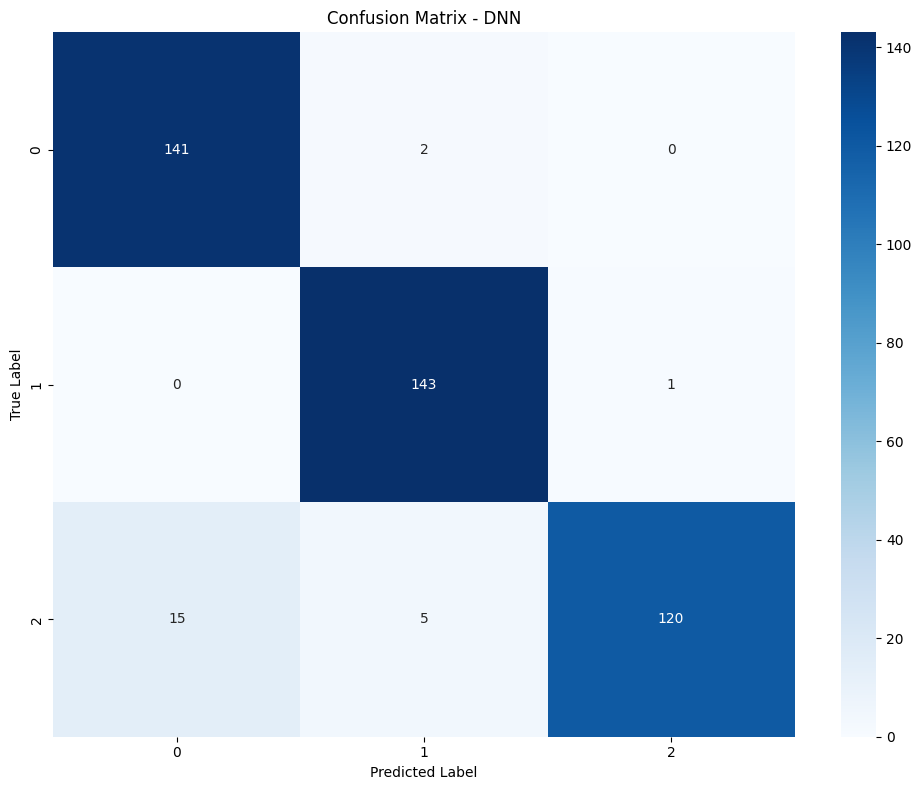

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step

===== CNN Evaluation Results =====
Accuracy: 0.9672
Precision: 0.9675
Recall: 0.9672
F1 Score: 0.9671

Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.98       143
           1       0.99      0.97      0.98       144
           2       0.96      0.94      0.95       140

    accuracy                           0.97       427
   macro avg       0.97      0.97      0.97       427
weighted avg       0.97      0.97      0.97       427



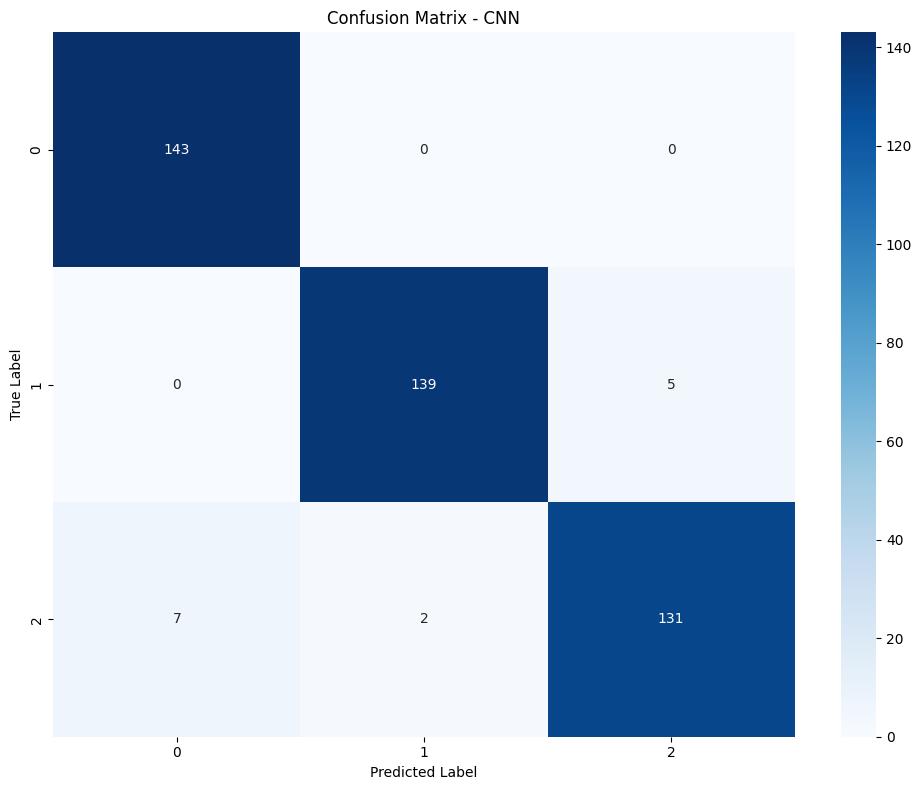

14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step

===== LSTM Evaluation Results =====
Accuracy: 0.9578
Precision: 0.9582
Recall: 0.9578
F1 Score: 0.9577

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.99      0.96       143
           1       0.98      0.97      0.98       144
           2       0.96      0.91      0.93       140

    accuracy                           0.96       427
   macro avg       0.96      0.96      0.96       427
weighted avg       0.96      0.96      0.96       427



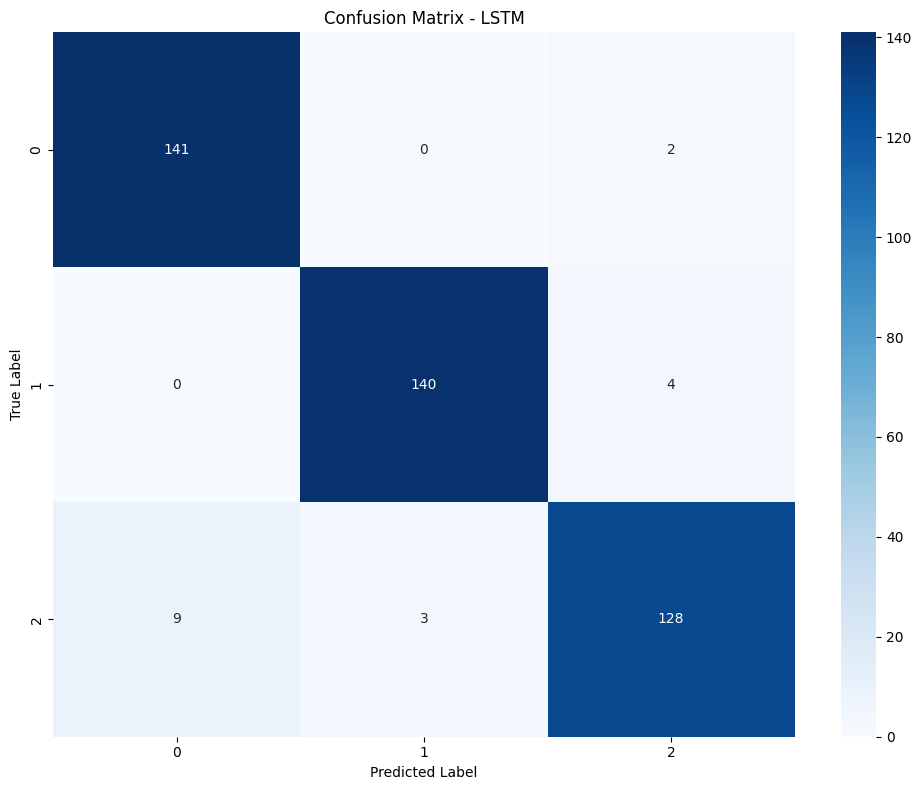

14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step

===== CNN-LSTM Ensemble Evaluation Results =====
Accuracy: 0.9672
Precision: 0.9673
Recall: 0.9672
F1 Score: 0.9670

Classification Report for Ensemble:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       143
           1       0.97      0.99      0.98       144
           2       0.97      0.93      0.95       140

    accuracy                           0.97       427
   macro avg       0.97      0.97      0.97       427
weighted avg       0.97      0.97      0.97       427



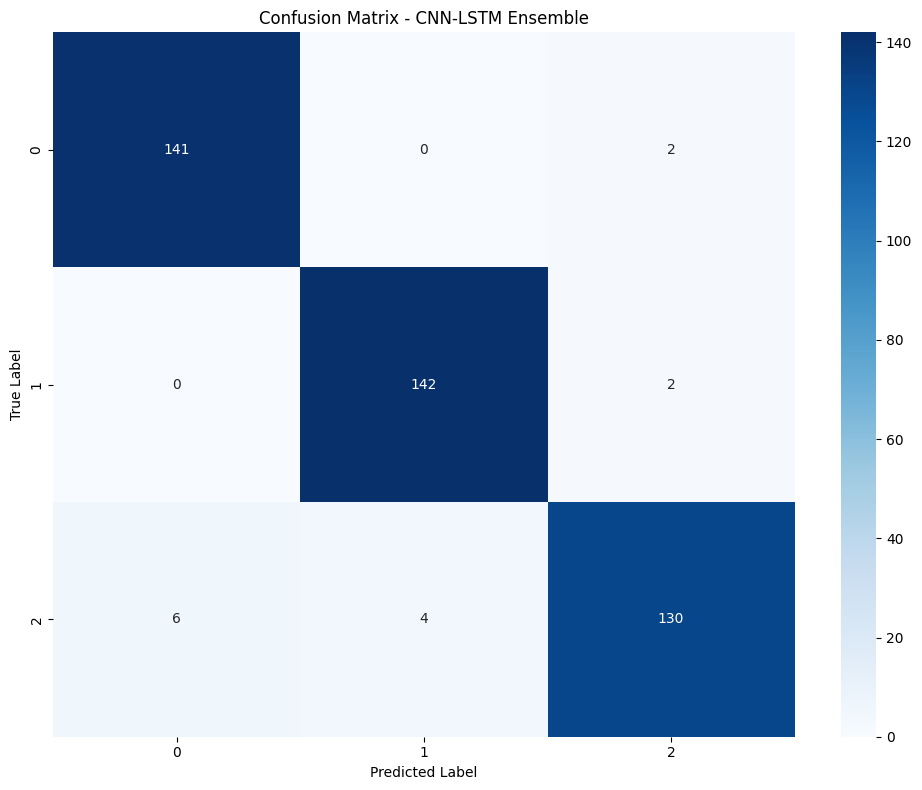


===== Model Performance Comparison =====
               Model  Accuracy  Precision    Recall  F1-Score
0                DNN  0.946136   0.949351  0.946136  0.945402
1                CNN  0.967213   0.967534  0.967213  0.967085
2               LSTM  0.957845   0.958151  0.957845  0.957663
3  CNN-LSTM Ensemble  0.967213   0.967304  0.967213  0.967032


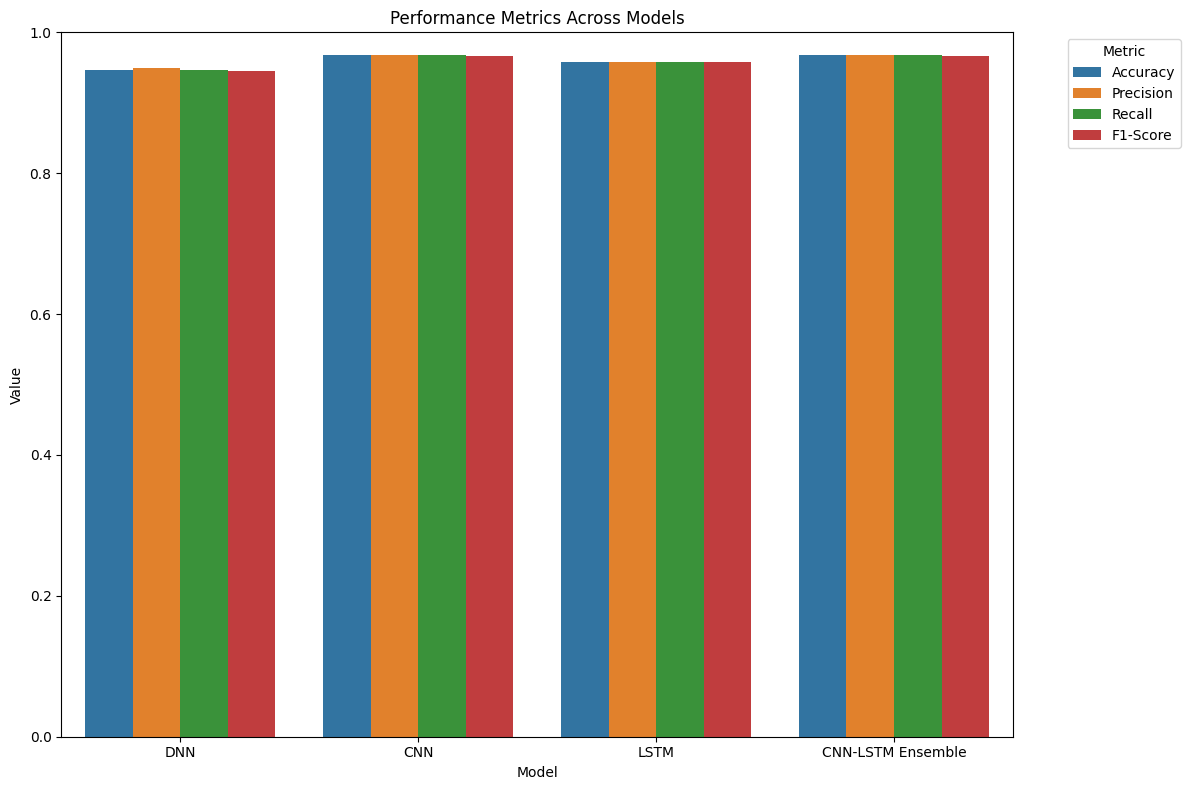

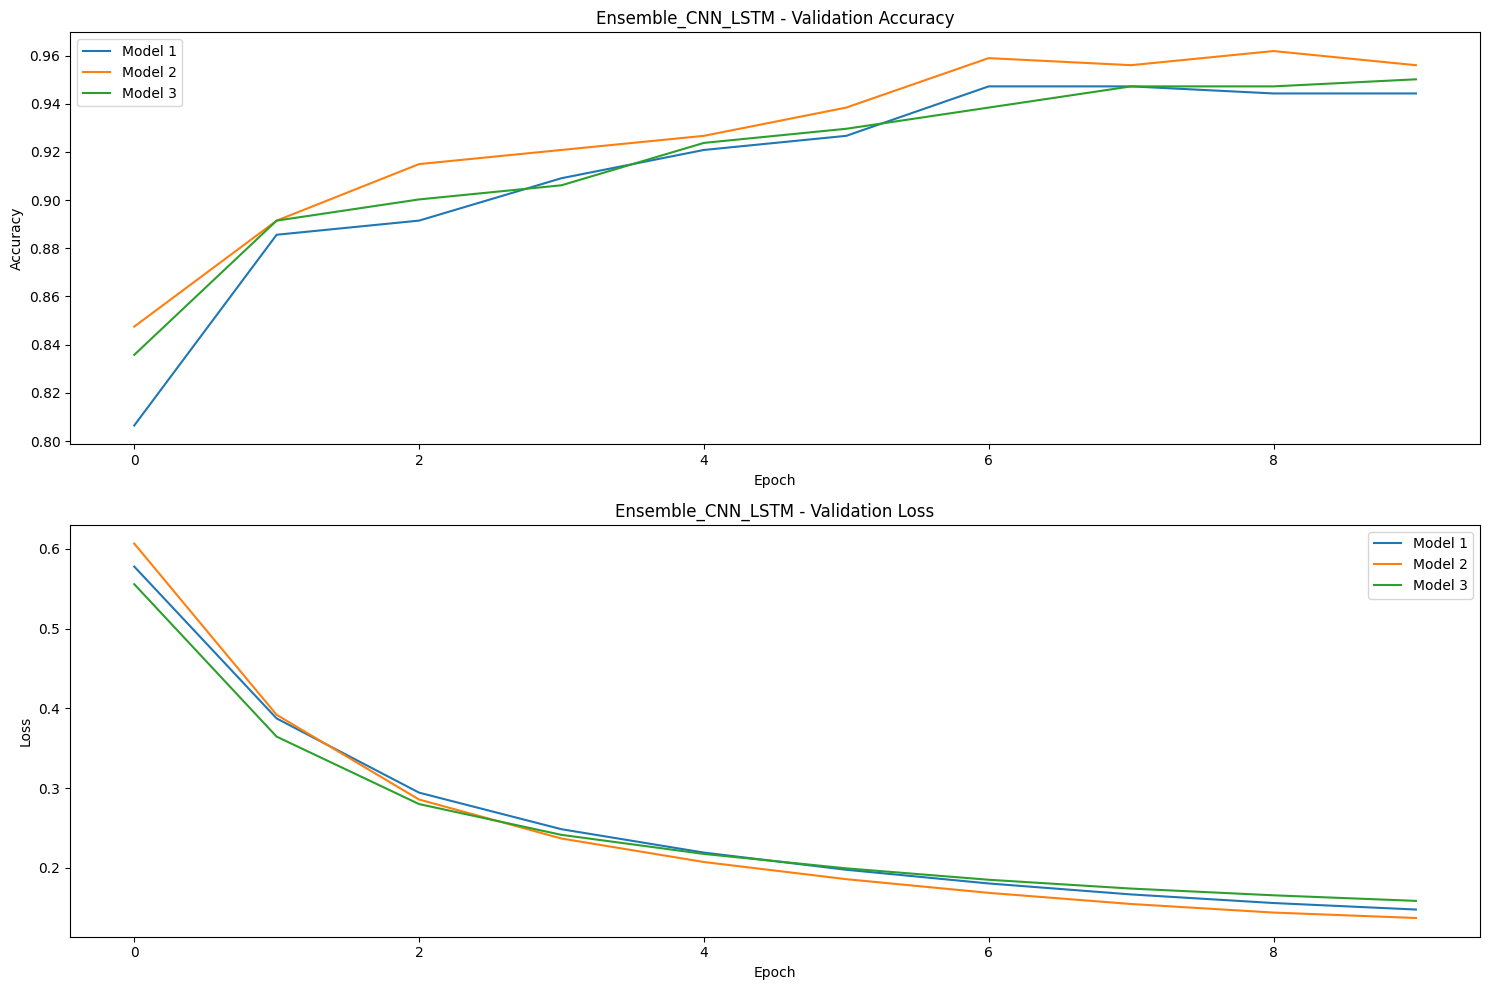

In [25]:
# Combined Main execution function
def main():
    # 1. Load and preprocess data
    print("Loading and preprocessing data...")

    # Load your data here
    data = pd.read_csv("/content/Drive/MyDrive/emotions.csv")

    # Preprocess labels
    le = LabelEncoder()
    data['label'] = le.fit_transform(data['label'])

    # Split features and target
    y = data.pop('label')
    X = data

    # Split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=48)

    # Reshape data for CNN models
    X_train = np.array(X_train).reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = np.array(X_test).reshape((X_test.shape[0], X_test.shape[1], 1))

    # Apply preprocessing
    X_train, X_test = preprocess_data(X_train, X_test)

    # Further split training data into train and validation
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

    # Get number of classes
    num_classes = len(np.unique(y))
    print(f"Number of emotion classes: {num_classes}")

    # Compute class weights to handle class imbalance
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train),
        y=y_train
    )
    class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}
    print("Class weights:", class_weight_dict)

    # Prepare data for different models
    print("\n===== Preparing data for different models =====")

    # For LSTM
    X_train_lstm, X_val_lstm = prepare_lstm_data(X_train, X_val)
    X_test_lstm, _ = prepare_lstm_data(X_test, X_test)

    # For CNN-LSTM - Use the fixed function
    X_train_cnn_lstm, X_val_cnn_lstm = prepare_cnn_lstm_data(X_train, X_val)
    X_test_cnn_lstm, _ = prepare_cnn_lstm_data(X_test, X_test)

    # 2. Train DNN model (original)
    print("\n===== Training DNN Model =====")
    dnn_model = create_dnn_model(X_train.shape[1:], num_classes)
    dnn_model.summary()
    dnn_model, dnn_history = train_model(
        dnn_model,
        X_train.reshape(X_train.shape[0], -1), y_train,
        X_val.reshape(X_val.shape[0], -1), y_val,
        "DNN",
        epochs=10  # Set to 10 epochs as specified
    )

    # 3. Train CNN model (original)
    print("\n===== Training CNN Model =====")
    cnn_model = create_cnn_model(X_train.shape[1:], num_classes)
    cnn_model.summary()
    cnn_model, cnn_history = train_model(
        cnn_model,
        X_train, y_train,
        X_val, y_val,
        "CNN",
        epochs=10  # Set to 10 epochs as specified
    )

    # 4. Train improved LSTM model
    print("\n===== Training Improved LSTM Model =====")
    lstm_model = create_lstm_model((X_train_lstm.shape[1], X_train_lstm.shape[2]), num_classes)
    lstm_model.summary()
    lstm_model, lstm_history = train_model(
        lstm_model,
        X_train_lstm, y_train,
        X_val_lstm, y_val,
        "LSTM",
        epochs=10  # Set to 10 epochs as specified
    )

    # 5. Train ensemble of CNN-LSTM models - Using the fixed implementation
    print("\n===== Training CNN-LSTM Ensemble =====")
    input_shape = (X_train_cnn_lstm.shape[1], X_train_cnn_lstm.shape[2], X_train_cnn_lstm.shape[3])
    print(f"Creating CNN-LSTM ensemble models with input shape: {input_shape}")

    # Use the fixed ensemble model creation function
    ensemble_models = create_ensemble_models(input_shape, num_classes, num_models=3)

    trained_ensemble, ensemble_histories = train_ensemble(
        ensemble_models,
        X_train_cnn_lstm, y_train,
        X_val_cnn_lstm, y_val,
        epochs=10,  # Set to 10 epochs as specified
        batch_size=24,
        class_weights=class_weight_dict
    )

    # 6. Evaluate all models
    print("\n===== Evaluating Models =====")

    # Evaluate DNN
    dnn_results = evaluate_model(
        dnn_model,
        X_test.reshape(X_test.shape[0], -1),
        y_test,
        "DNN"
    )

    # Evaluate CNN
    cnn_results = evaluate_model(
        cnn_model,
        X_test,
        y_test,
        "CNN"
    )

    # Evaluate LSTM
    lstm_results = evaluate_model(
        lstm_model,
        X_test_lstm,
        y_test,
        "LSTM"
    )

    # Evaluate CNN-LSTM ensemble
    ensemble_preds, ensemble_probs = ensemble_predict(trained_ensemble, X_test_cnn_lstm)

    # Create a temporary model for evaluation purposes
    ensemble_results = {
        'accuracy': accuracy_score(y_test, ensemble_preds),
        'precision': precision_recall_fscore_support(y_test, ensemble_preds, average='weighted')[0],
        'recall': precision_recall_fscore_support(y_test, ensemble_preds, average='weighted')[1],
        'f1': precision_recall_fscore_support(y_test, ensemble_preds, average='weighted')[2],
        'confusion_matrix': confusion_matrix(y_test, ensemble_preds),
        'predictions': ensemble_preds,
        'probabilities': ensemble_probs
    }

    # Print ensemble results
    print("\n===== CNN-LSTM Ensemble Evaluation Results =====")
    print(f"Accuracy: {ensemble_results['accuracy']:.4f}")
    print(f"Precision: {ensemble_results['precision']:.4f}")
    print(f"Recall: {ensemble_results['recall']:.4f}")
    print(f"F1 Score: {ensemble_results['f1']:.4f}")

    # Print classification report for ensemble
    print("\nClassification Report for Ensemble:")
    print(classification_report(y_test, ensemble_preds))

    # Plot confusion matrix for ensemble
    plt.figure(figsize=(10, 8))
    sns.heatmap(ensemble_results['confusion_matrix'], annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix - CNN-LSTM Ensemble')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.savefig("CNN_LSTM_Ensemble_confusion_matrix.png")
    plt.show()

    # 7. Compare model performances
    print("\n===== Model Performance Comparison =====")
    results = {
        "Model": ["DNN", "CNN", "LSTM", "CNN-LSTM Ensemble"],
        "Accuracy": [
            dnn_results['accuracy'],
            cnn_results['accuracy'],
            lstm_results['accuracy'],
            ensemble_results['accuracy']
        ],
        "Precision": [
            dnn_results['precision'],
            cnn_results['precision'],
            lstm_results['precision'],
            ensemble_results['precision']
        ],
        "Recall": [
            dnn_results['recall'],
            cnn_results['recall'],
            lstm_results['recall'],
            ensemble_results['recall']
        ],
        "F1-Score": [
            dnn_results['f1'],
            cnn_results['f1'],
            lstm_results['f1'],
            ensemble_results['f1']
        ]
    }

    # Create results dataframe
    results_df = pd.DataFrame(results)
    print(results_df)

    # Plot results comparison
    plt.figure(figsize=(12, 8))

    # Reshape data for grouped bar chart
    metrics_df = pd.melt(
        results_df,
        id_vars=['Model'],
        value_vars=['Accuracy', 'Precision', 'Recall', 'F1-Score'],
        var_name='Metric',
        value_name='Value'
    )

    # Create grouped bar chart
    sns.barplot(x='Model', y='Value', hue='Metric', data=metrics_df)
    plt.title('Performance Metrics Across Models')
    plt.ylim(0, 1)
    plt.legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.savefig('model_comparison.png')
    plt.show()

    # Plot ensemble histories
    plot_ensemble_histories(ensemble_histories)

    return {
        'dnn_model': dnn_model,
        'cnn_model': cnn_model,
        'lstm_model': lstm_model,
        'ensemble_models': trained_ensemble,
        'results': results_df
    }

# Execute the main function if this script is run directly
if __name__ == "__main__":
    # Set memory growth for GPU if available
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
        except RuntimeError as e:
            print(e)

    # Run the main function
    results = main()

CNN LSTM Model's main Function

In [24]:
# Main execution function (with fixes)
def main():
    # 1. Load and preprocess data
    # This assumes data is already loaded and preprocessed as in your original code
    print("Loading and preprocessing data...")

    # Load your data here
    data = pd.read_csv("/content/Drive/MyDrive/emotions.csv")

    # Preprocess labels
    le = LabelEncoder()
    data['label'] = le.fit_transform(data['label'])

    # Split features and target
    y = data.pop('label')
    X = data

    # Split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=48)

    # Reshape data for CNN models
    X_train = np.array(X_train).reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = np.array(X_test).reshape((X_test.shape[0], X_test.shape[1], 1))

    # Apply preprocessing
    X_train, X_test = preprocess_data(X_train, X_test)

    # Further split training data into train and validation
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

    # Get number of classes
    num_classes = len(np.unique(y))
    print(f"Number of emotion classes: {num_classes}")

    # Compute class weights to handle class imbalance
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train),
        y=y_train
    )
    class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}
    print("Class weights:", class_weight_dict)

    # Prepare data for different models
    print("\n===== Preparing data for different models =====")

    # For LSTM
    X_train_lstm, X_val_lstm = prepare_lstm_data(X_train, X_val)
    X_test_lstm, _ = prepare_lstm_data(X_test, X_test)

    # For CNN-LSTM - Use the fixed function
    X_train_cnn_lstm, X_val_cnn_lstm = prepare_cnn_lstm_data(X_train, X_val)
    X_test_cnn_lstm, _ = prepare_cnn_lstm_data(X_test, X_test)

    # 2-4. Train DNN, CNN, and LSTM models (unchanged)

    # 5. Train ensemble of CNN-LSTM models - Using the fixed implementation
    print("\n===== Training CNN-LSTM Ensemble =====")
    input_shape = (X_train_cnn_lstm.shape[1], X_train_cnn_lstm.shape[2], X_train_cnn_lstm.shape[3])
    print(f"Creating CNN-LSTM ensemble models with input shape: {input_shape}")

    # Use the fixed ensemble model creation function
    ensemble_models = create_ensemble_models(input_shape, num_classes, num_models=3)

    trained_ensemble, ensemble_histories = train_ensemble(
        ensemble_models,
        X_train_cnn_lstm, y_train,
        X_val_cnn_lstm, y_val,
        epochs=30,
        batch_size=24,
        class_weights=class_weight_dict
    )

    # 6. Evaluate all models
    # Rest of the code remains unchanged...

    return {
        'dnn_model': dnn_model,
        'cnn_model': cnn_model,
        'lstm_model': lstm_model,
        'ensemble_models': trained_ensemble,
        'results': results_df
    }

# Execute the main function if this script is run directly
if __name__ == "__main__":
    # Set memory growth for GPU if available
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
        except RuntimeError as e:
            print(e)

    # Run the main function
    results = main()

Loading and preprocessing data...
Number of emotion classes: 3
Class weights: {0: np.float64(0.9992673992673993), 1: np.float64(0.9970760233918129), 2: np.float64(1.0036791758646064)}

===== Preparing data for different models =====
Original shapes: (1364, 2548, 1) (341, 2548, 1)
LSTM data reshaped to: (1364, 10, 254) with 10 time steps and 254 features per step
Original shapes: (427, 2548, 1) (427, 2548, 1)
LSTM data reshaped to: (427, 10, 254) with 10 time steps and 254 features per step
Original CNN-LSTM input shapes: (1364, 2548, 1) (341, 2548, 1)
Total features: 2548
Using 2500 features (50 per subsequence)
CNN-LSTM data reshaped to: (1364, 10, 5, 50)
Original CNN-LSTM input shapes: (427, 2548, 1) (427, 2548, 1)
Total features: 2548
Using 2500 features (50 per subsequence)
CNN-LSTM data reshaped to: (427, 10, 5, 50)

===== Training CNN-LSTM Ensemble =====
Creating CNN-LSTM ensemble models with input shape: (10, 5, 50)
Creating 3 ensemble models with input shape: (10, 5, 50)

Initi

57/57 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.6678 - loss: 0.9102 - val_accuracy: 0.8065 - val_loss: 0.5780 - learning_rate: 1.0000e-04
Epoch 2/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.8338 - loss: 0.5218
Epoch 2: val_accuracy improved from 0.80645 to 0.88563, saving model to model_checkpoints/ensemble_cnn_lstm_0_best.h5


57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.8344 - loss: 0.5207 - val_accuracy: 0.8856 - val_loss: 0.3873 - learning_rate: 1.0000e-04
Epoch 3/30
56/57 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8871 - loss: 0.3595
Epoch 3: val_accuracy improved from 0.88563 to 0.89150, saving model to model_checkpoints/ensemble_cnn_lstm_0_best.h5


57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.8877 - loss: 0.3580 - val_accuracy: 0.8915 - val_loss: 0.2942 - learning_rate: 1.0000e-04
Epoch 4/30
56/57 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8929 - loss: 0.2807
Epoch 4: val_accuracy improved from 0.89150 to 0.90909, saving model to model_checkpoints/ensemble_cnn_lstm_0_best.h5


57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.8935 - loss: 0.2797 - val_accuracy: 0.9091 - val_loss: 0.2483 - learning_rate: 1.0000e-04
Epoch 5/30
56/57 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9005 - loss: 0.2360
Epoch 5: val_accuracy improved from 0.90909 to 0.92082, saving model to model_checkpoints/ensemble_cnn_lstm_0_best.h5


57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.9011 - loss: 0.2352 - val_accuracy: 0.9208 - val_loss: 0.2190 - learning_rate: 1.0000e-04
Epoch 6/30
56/57 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9147 - loss: 0.2011
Epoch 6: val_accuracy improved from 0.92082 to 0.92669, saving model to model_checkpoints/ensemble_cnn_lstm_0_best.h5


57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.9153 - loss: 0.2004 - val_accuracy: 0.9267 - val_loss: 0.1974 - learning_rate: 1.0000e-04
Epoch 7/30
55/57 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9349 - loss: 0.1696
Epoch 7: val_accuracy improved from 0.92669 to 0.94721, saving model to model_checkpoints/ensemble_cnn_lstm_0_best.h5


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.9358 - loss: 0.1688 - val_accuracy: 0.9472 - val_loss: 0.1802 - learning_rate: 1.0000e-04
Epoch 8/30
55/57 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9622 - loss: 0.1389
Epoch 8: val_accuracy did not improve from 0.94721
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.9624 - loss: 0.1383 - val_accuracy: 0.9472 - val_loss: 0.1665 - learning_rate: 1.0000e-04
Epoch 9/30
55/57 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9708 - loss: 0.1093
Epoch 9: val_accuracy did not improve from 0.94721
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.9710 - loss: 0.1088 - val_accuracy: 0.9443 - val_loss: 0.1557 - learning_rate: 1.0000e-04
Epoch 10/30
56/57 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9809 - loss: 0.0813
Epoch 10: val_accuracy did not improve from 0.94721
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.9809 - loss: 0.0811 - val_accuracy: 0.9443 - val_loss: 0.1475 - learning_rate: 1.0000e-04
Epoch 11/30
56

57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.9960 - loss: 0.0395 - val_accuracy: 0.9560 - val_loss: 0.1343 - learning_rate: 1.0000e-04
Epoch 13/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9978 - loss: 0.0279
Epoch 13: val_accuracy improved from 0.95601 to 0.95894, saving model to model_checkpoints/ensemble_cnn_lstm_0_best.h5


57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.9978 - loss: 0.0278 - val_accuracy: 0.9589 - val_loss: 0.1343 - learning_rate: 1.0000e-04
Epoch 14/30
56/57 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9986 - loss: 0.0210
Epoch 14: val_accuracy did not improve from 0.95894
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.9986 - loss: 0.0209 - val_accuracy: 0.9560 - val_loss: 0.1368 - learning_rate: 1.0000e-04
Epoch 15/30
56/57 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9986 - loss: 0.0167
Epoch 15: val_accuracy did not improve from 0.95894
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.9986 - loss: 0.0167 - val_accuracy: 0.9560 - val_loss: 0.1355 - learning_rate: 1.0000e-04
Epoch 16/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9991 - loss: 0.0136
Epoch 16: val_accuracy did not improve from 0.95894
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.9991 - loss: 0.0136 - val_accuracy: 0.9589 - val_loss: 0.1336 - learning_rate: 1.0000e-04
Epoch 17/3

57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.9991 - loss: 0.0117 - val_accuracy: 0.9619 - val_loss: 0.1338 - learning_rate: 1.0000e-04
Epoch 18/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9991 - loss: 0.0103
Epoch 18: val_accuracy did not improve from 0.96188
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.9991 - loss: 0.0103 - val_accuracy: 0.9619 - val_loss: 0.1348 - learning_rate: 1.0000e-04
Epoch 19/30
55/57 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9991 - loss: 0.0093
Epoch 19: val_accuracy did not improve from 0.96188
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.9991 - loss: 0.0092 - val_accuracy: 0.9619 - val_loss: 0.1363 - learning_rate: 1.0000e-04
Epoch 19: early stopping
Restoring model weights from the end of the best epoch: 16.

===== Training Ensemble Model 2/3 =====
Epoch 1/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6223 - loss: 0.9458
Epoch 1: val_accuracy improved from -inf to 0.84751, saving model to model_checkp

57/57 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.6244 - loss: 0.9435 - val_accuracy: 0.8475 - val_loss: 0.6068 - learning_rate: 1.0000e-04
Epoch 2/30
56/57 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.8466 - loss: 0.5550
Epoch 2: val_accuracy improved from 0.84751 to 0.89150, saving model to model_checkpoints/ensemble_cnn_lstm_1_best.h5


57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.8476 - loss: 0.5525 - val_accuracy: 0.8915 - val_loss: 0.3919 - learning_rate: 1.0000e-04
Epoch 3/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8920 - loss: 0.3660
Epoch 3: val_accuracy improved from 0.89150 to 0.91496, saving model to model_checkpoints/ensemble_cnn_lstm_1_best.h5


57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.8923 - loss: 0.3652 - val_accuracy: 0.9150 - val_loss: 0.2856 - learning_rate: 1.0000e-04
Epoch 4/30
55/57 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9011 - loss: 0.2770
Epoch 4: val_accuracy improved from 0.91496 to 0.92082, saving model to model_checkpoints/ensemble_cnn_lstm_1_best.h5


57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.9020 - loss: 0.2756 - val_accuracy: 0.9208 - val_loss: 0.2366 - learning_rate: 1.0000e-04
Epoch 5/30
55/57 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9074 - loss: 0.2287
Epoch 5: val_accuracy improved from 0.92082 to 0.92669, saving model to model_checkpoints/ensemble_cnn_lstm_1_best.h5


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.9083 - loss: 0.2276 - val_accuracy: 0.9267 - val_loss: 0.2072 - learning_rate: 1.0000e-04
Epoch 6/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9274 - loss: 0.1925
Epoch 6: val_accuracy improved from 0.92669 to 0.93842, saving model to model_checkpoints/ensemble_cnn_lstm_1_best.h5


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.9276 - loss: 0.1922 - val_accuracy: 0.9384 - val_loss: 0.1856 - learning_rate: 1.0000e-04
Epoch 7/30
56/57 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9462 - loss: 0.1612
Epoch 7: val_accuracy improved from 0.93842 to 0.95894, saving model to model_checkpoints/ensemble_cnn_lstm_1_best.h5


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.9465 - loss: 0.1608 - val_accuracy: 0.9589 - val_loss: 0.1684 - learning_rate: 1.0000e-04
Epoch 8/30
56/57 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9631 - loss: 0.1310
Epoch 8: val_accuracy did not improve from 0.95894
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.9633 - loss: 0.1307 - val_accuracy: 0.9560 - val_loss: 0.1545 - learning_rate: 1.0000e-04
Epoch 9/30
55/57 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9740 - loss: 0.1018
Epoch 9: val_accuracy improved from 0.95894 to 0.96188, saving model to model_checkpoints/ensemble_cnn_lstm_1_best.h5


57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.9741 - loss: 0.1015 - val_accuracy: 0.9619 - val_loss: 0.1437 - learning_rate: 1.0000e-04
Epoch 10/30
55/57 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9844 - loss: 0.0747
Epoch 10: val_accuracy did not improve from 0.96188
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.9844 - loss: 0.0745 - val_accuracy: 0.9560 - val_loss: 0.1369 - learning_rate: 1.0000e-04
Epoch 11/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9907 - loss: 0.0519
Epoch 11: val_accuracy did not improve from 0.96188
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.9906 - loss: 0.0519 - val_accuracy: 0.9589 - val_loss: 0.1303 - learning_rate: 1.0000e-04
Epoch 12/30
56/57 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9966 - loss: 0.0343
Epoch 12: val_accuracy did not improve from 0.96188
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - accuracy: 0.9966 - loss: 0.0342 - val_accuracy: 0.9560 - val_loss: 0.1267 - learning_rate: 1.0000e-04
Epoch 13/3

57/57 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - accuracy: 0.6345 - loss: 0.8837 - val_accuracy: 0.8358 - val_loss: 0.5558 - learning_rate: 1.0000e-04
Epoch 2/30
56/57 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8584 - loss: 0.5078
Epoch 2: val_accuracy improved from 0.83578 to 0.89150, saving model to model_checkpoints/ensemble_cnn_lstm_2_best.h5


57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.8594 - loss: 0.5055 - val_accuracy: 0.8915 - val_loss: 0.3645 - learning_rate: 1.0000e-04
Epoch 3/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8835 - loss: 0.3452
Epoch 3: val_accuracy improved from 0.89150 to 0.90029, saving model to model_checkpoints/ensemble_cnn_lstm_2_best.h5


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.8838 - loss: 0.3445 - val_accuracy: 0.9003 - val_loss: 0.2799 - learning_rate: 1.0000e-04
Epoch 4/30
56/57 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8924 - loss: 0.2728
Epoch 4: val_accuracy improved from 0.90029 to 0.90616, saving model to model_checkpoints/ensemble_cnn_lstm_2_best.h5


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.8930 - loss: 0.2719 - val_accuracy: 0.9062 - val_loss: 0.2412 - learning_rate: 1.0000e-04
Epoch 5/30
56/57 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9051 - loss: 0.2316
Epoch 5: val_accuracy improved from 0.90616 to 0.92375, saving model to model_checkpoints/ensemble_cnn_lstm_2_best.h5


57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.9057 - loss: 0.2309 - val_accuracy: 0.9238 - val_loss: 0.2173 - learning_rate: 1.0000e-04
Epoch 6/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9172 - loss: 0.1985
Epoch 6: val_accuracy improved from 0.92375 to 0.92962, saving model to model_checkpoints/ensemble_cnn_lstm_2_best.h5


57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - accuracy: 0.9175 - loss: 0.1982 - val_accuracy: 0.9296 - val_loss: 0.1992 - learning_rate: 1.0000e-04
Epoch 7/30
55/57 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9390 - loss: 0.1679
Epoch 7: val_accuracy improved from 0.92962 to 0.93842, saving model to model_checkpoints/ensemble_cnn_lstm_2_best.h5


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.9398 - loss: 0.1671 - val_accuracy: 0.9384 - val_loss: 0.1849 - learning_rate: 1.0000e-04
Epoch 8/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9579 - loss: 0.1364
Epoch 8: val_accuracy improved from 0.93842 to 0.94721, saving model to model_checkpoints/ensemble_cnn_lstm_2_best.h5


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.9580 - loss: 0.1363 - val_accuracy: 0.9472 - val_loss: 0.1738 - learning_rate: 1.0000e-04
Epoch 9/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9753 - loss: 0.1067
Epoch 9: val_accuracy did not improve from 0.94721
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.9753 - loss: 0.1066 - val_accuracy: 0.9472 - val_loss: 0.1654 - learning_rate: 1.0000e-04
Epoch 10/30
55/57 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9857 - loss: 0.0796
Epoch 10: val_accuracy improved from 0.94721 to 0.95015, saving model to model_checkpoints/ensemble_cnn_lstm_2_best.h5


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.9855 - loss: 0.0794 - val_accuracy: 0.9501 - val_loss: 0.1584 - learning_rate: 1.0000e-04
Epoch 11/30
55/57 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9911 - loss: 0.0554
Epoch 11: val_accuracy improved from 0.95015 to 0.95308, saving model to model_checkpoints/ensemble_cnn_lstm_2_best.h5


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.9909 - loss: 0.0553 - val_accuracy: 0.9531 - val_loss: 0.1493 - learning_rate: 1.0000e-04
Epoch 12/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9941 - loss: 0.0374
Epoch 12: val_accuracy improved from 0.95308 to 0.95894, saving model to model_checkpoints/ensemble_cnn_lstm_2_best.h5


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.9941 - loss: 0.0374 - val_accuracy: 0.9589 - val_loss: 0.1396 - learning_rate: 1.0000e-04
Epoch 13/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9986 - loss: 0.0254
Epoch 13: val_accuracy improved from 0.95894 to 0.96188, saving model to model_checkpoints/ensemble_cnn_lstm_2_best.h5


57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.9986 - loss: 0.0254 - val_accuracy: 0.9619 - val_loss: 0.1384 - learning_rate: 1.0000e-04
Epoch 14/30
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9995 - loss: 0.0170
Epoch 14: val_accuracy did not improve from 0.96188
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.9995 - loss: 0.0170 - val_accuracy: 0.9589 - val_loss: 0.1407 - learning_rate: 1.0000e-04
Epoch 15/30
56/57 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9995 - loss: 0.0127
Epoch 15: val_accuracy did not improve from 0.96188
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.9995 - loss: 0.0127 - val_accuracy: 0.9589 - val_loss: 0.1434 - learning_rate: 1.0000e-04
Epoch 16/30
55/57 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9995 - loss: 0.0102
Epoch 16: val_accuracy did not improve from 0.96188
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.9995 - loss: 0.0103 - val_accuracy: 0.9560 - val_loss: 0.1476 - learning_rate: 1.0000e-04
Epoch 16: 

NameError: name 'dnn_model' is not defined

DNN CNN LSTM Models

In [17]:
# Main execution function
def main():
    # 1. Load and preprocess data
    # This assumes data is already loaded and preprocessed as in your original code
    # You would need to adapt this to your actual data loading process
    print("Loading and preprocessing data...")

    # Load your data here
    data = pd.read_csv("/content/Drive/MyDrive/emotions.csv")

    # Preprocess labels
    le = LabelEncoder()
    data['label'] = le.fit_transform(data['label'])

    # Split features and target
    y = data.pop('label')
    X = data

    # Split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=48)

    # Reshape data for CNN models
    X_train = np.array(X_train).reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = np.array(X_test).reshape((X_test.shape[0], X_test.shape[1], 1))

    # Apply preprocessing
    X_train, X_test = preprocess_data(X_train, X_test)

    # Further split training data into train and validation
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

    # Get number of classes
    num_classes = len(np.unique(y))
    print(f"Number of emotion classes: {num_classes}")

    # Compute class weights to handle class imbalance
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train),
        y=y_train
    )
    class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}
    print("Class weights:", class_weight_dict)

    # Prepare data for different models
    print("\n===== Preparing data for different models =====")

    # For LSTM
    X_train_lstm, X_val_lstm = prepare_lstm_data(X_train, X_val)
    X_test_lstm, _ = prepare_lstm_data(X_test, X_test)

    # For CNN-LSTM
    X_train_cnn_lstm, X_val_cnn_lstm = prepare_cnn_lstm_data(X_train, X_val)
    X_test_cnn_lstm, _ = prepare_cnn_lstm_data(X_test, X_test)

    # 2. Train DNN model (original)
    print("\n===== Training DNN Model =====")
    dnn_model = create_dnn_model(X_train.shape[1:], num_classes)
    dnn_model.summary()
    dnn_model, dnn_history = train_model(
        dnn_model,
        X_train.reshape(X_train.shape[0], -1), y_train,
        X_val.reshape(X_val.shape[0], -1), y_val,
        "DNN",
        epochs=30
    )

    # 3. Train CNN model (original)
    print("\n===== Training CNN Model =====")
    cnn_model = create_cnn_model(X_train.shape[1:], num_classes)
    cnn_model.summary()
    cnn_model, cnn_history = train_model(
        cnn_model,
        X_train, y_train,
        X_val, y_val,
        "CNN",
        epochs=10
    )

    # 4. Train improved LSTM model
    print("\n===== Training Improved LSTM Model =====")
    lstm_model = create_lstm_model((X_train_lstm.shape[1], X_train_lstm.shape[2]), num_classes)
    lstm_model.summary()
    lstm_model, lstm_history = train_model(
        lstm_model,
        X_train_lstm, y_train,
        X_val_lstm, y_val,
        "LSTM",
        epochs=10
    )

    # 5. Train ensemble of CNN-LSTM models
    print("\n===== Training CNN-LSTM Ensemble =====")
    input_shape = (X_train_cnn_lstm.shape[1], X_train_cnn_lstm.shape[2], X_train_cnn_lstm.shape[3])
    ensemble_models = create_ensemble_models(input_shape, num_classes, num_models=3)

    trained_ensemble, ensemble_histories = train_ensemble(
        ensemble_models,
        X_train_cnn_lstm, y_train,
        X_val_cnn_lstm, y_val,
        epochs=10,
        batch_size=24,
        class_weights=class_weight_dict
    )

    # 6. Evaluate all models
    print("\n===== Evaluating Models =====")

    # Evaluate DNN
    dnn_results = evaluate_model(
        dnn_model,
        X_test.reshape(X_test.shape[0], -1),
        y_test,
        "DNN"
    )

    # Evaluate CNN
    cnn_results = evaluate_model(
        cnn_model,
        X_test,
        y_test,
        "CNN"
    )

    # Evaluate LSTM
    lstm_results = evaluate_model(
        lstm_model,
        X_test_lstm,
        y_test,
        "LSTM"
    )

    # Evaluate CNN-LSTM ensemble
    ensemble_preds, ensemble_probs = ensemble_predict(trained_ensemble, X_test_cnn_lstm)

    # Create a temporary model for evaluation purposes
    ensemble_results = {
        'accuracy': accuracy_score(y_test, ensemble_preds),
        'precision': precision_recall_fscore_support(y_test, ensemble_preds, average='weighted')[0],
        'recall': precision_recall_fscore_support(y_test, ensemble_preds, average='weighted')[1],
        'f1': precision_recall_fscore_support(y_test, ensemble_preds, average='weighted')[2],
        'confusion_matrix': confusion_matrix(y_test, ensemble_preds),
        'predictions': ensemble_preds,
        'probabilities': ensemble_probs
    }

    # Print ensemble results
    print("\n===== CNN-LSTM Ensemble Evaluation Results =====")
    print(f"Accuracy: {ensemble_results['accuracy']:.4f}")
    print(f"Precision: {ensemble_results['precision']:.4f}")
    print(f"Recall: {ensemble_results['recall']:.4f}")
    print(f"F1 Score: {ensemble_results['f1']:.4f}")

    # Print classification report for ensemble
    print("\nClassification Report for Ensemble:")
    print(classification_report(y_test, ensemble_preds))

    # Plot confusion matrix for ensemble
    plt.figure(figsize=(10, 8))
    sns.heatmap(ensemble_results['confusion_matrix'], annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix - CNN-LSTM Ensemble')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.savefig("CNN_LSTM_Ensemble_confusion_matrix.png")
    plt.show()

    # 7. Compare model performances
    print("\n===== Model Performance Comparison =====")
    results = {
        "Model": ["DNN", "CNN", "LSTM", "CNN-LSTM Ensemble"],
        "Accuracy": [
            dnn_results['accuracy'],
            cnn_results['accuracy'],
            lstm_results['accuracy'],
            ensemble_results['accuracy']
        ],
        "Precision": [
            dnn_results['precision'],
            cnn_results['precision'],
            lstm_results['precision'],
            ensemble_results['precision']
        ],
        "Recall": [
            dnn_results['recall'],
            cnn_results['recall'],
            lstm_results['recall'],
            ensemble_results['recall']
        ],
        "F1-Score": [
            dnn_results['f1'],
            cnn_results['f1'],
            lstm_results['f1'],
            ensemble_results['f1']
        ]
    }

    # Create results dataframe
    results_df = pd.DataFrame(results)
    print(results_df)

    # Plot results comparison
    plt.figure(figsize=(12, 8))

    # Reshape data for grouped bar chart
    metrics_df = pd.melt(
        results_df,
        id_vars=['Model'],
        value_vars=['Accuracy', 'Precision', 'Recall', 'F1-Score'],
        var_name='Metric',
        value_name='Value'
    )

    # Create grouped bar chart
    sns.barplot(x='Model', y='Value', hue='Metric', data=metrics_df)
    plt.title('Performance Metrics Across Models')
    plt.ylim(0, 1)
    plt.legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.savefig('model_comparison.png')
    plt.show()

    # Plot ensemble histories
    plot_ensemble_histories(ensemble_histories)

    return {
        'dnn_model': dnn_model,
        'cnn_model': cnn_model,
        'lstm_model': lstm_model,
        'ensemble_models': trained_ensemble,
        'results': results_df
    }

# Execute the main function if this script is run directly
if __name__ == "__main__":
    results = main()

Loading and preprocessing data...
Number of emotion classes: 3
Class weights: {0: np.float64(0.9992673992673993), 1: np.float64(0.9970760233918129), 2: np.float64(1.0036791758646064)}

===== Preparing data for different models =====
Original shapes: (1364, 2548, 1) (341, 2548, 1)
LSTM data reshaped to: (1364, 10, 254) with 10 time steps and 254 features per step
Original shapes: (427, 2548, 1) (427, 2548, 1)
LSTM data reshaped to: (427, 10, 254) with 10 time steps and 254 features per step
Original CNN-LSTM input shapes: (1364, 2548, 1) (341, 2548, 1)
CNN-LSTM data reshaped to: (1364, 10, 5, 50)
Original CNN-LSTM input shapes: (427, 2548, 1) (427, 2548, 1)
CNN-LSTM data reshaped to: (427, 10, 5, 50)

===== Training DNN Model =====


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 2548)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       326,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 334,723 (1.28 MB)

 Trainable params: 334,723 (1.28 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5841 - loss: 2.6443
Epoch 1: val_accuracy improved from -inf to 0.82111, saving model to model_checkpoints/DNN_best.h5


43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.5853 - loss: 2.6359 - val_accuracy: 0.8211 - val_loss: 1.0233 - learning_rate: 1.0000e-04
Epoch 2/30
38/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7304 - loss: 1.4035
Epoch 2: val_accuracy improved from 0.82111 to 0.86510, saving model to model_checkpoints/DNN_best.h5


43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7310 - loss: 1.4158 - val_accuracy: 0.8651 - val_loss: 0.8879 - learning_rate: 1.0000e-04
Epoch 3/30
39/43 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7937 - loss: 1.2244
Epoch 3: val_accuracy improved from 0.86510 to 0.88856, saving model to model_checkpoints/DNN_best.h5


43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7940 - loss: 1.2175 - val_accuracy: 0.8886 - val_loss: 0.7579 - learning_rate: 1.0000e-04
Epoch 4/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7983 - loss: 1.1625
Epoch 4: val_accuracy did not improve from 0.88856
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7986 - loss: 1.1615 - val_accuracy: 0.8827 - val_loss: 0.7136 - learning_rate: 1.0000e-04
Epoch 5/30
41/43 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8225 - loss: 1.0758
Epoch 5: val_accuracy improved from 0.88856 to 0.89736, saving model to model_checkpoints/DNN_best.h5


43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8229 - loss: 1.0747 - val_accuracy: 0.8974 - val_loss: 0.6867 - learning_rate: 1.0000e-04
Epoch 6/30
38/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8409 - loss: 0.9944
Epoch 6: val_accuracy did not improve from 0.89736
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8401 - loss: 1.0017 - val_accuracy: 0.8886 - val_loss: 0.6990 - learning_rate: 1.0000e-04
Epoch 7/30
37/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8519 - loss: 0.9058
Epoch 7: val_accuracy improved from 0.89736 to 0.90029, saving model to model_checkpoints/DNN_best.h5


43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8519 - loss: 0.9044 - val_accuracy: 0.9003 - val_loss: 0.6424 - learning_rate: 1.0000e-04
Epoch 8/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8705 - loss: 0.8631
Epoch 8: val_accuracy improved from 0.90029 to 0.90323, saving model to model_checkpoints/DNN_best.h5


43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8702 - loss: 0.8637 - val_accuracy: 0.9032 - val_loss: 0.6262 - learning_rate: 1.0000e-04
Epoch 9/30
37/43 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8847 - loss: 0.7503
Epoch 9: val_accuracy improved from 0.90323 to 0.91202, saving model to model_checkpoints/DNN_best.h5


43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8828 - loss: 0.7591 - val_accuracy: 0.9120 - val_loss: 0.6375 - learning_rate: 1.0000e-04
Epoch 10/30
40/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8829 - loss: 0.6826
Epoch 10: val_accuracy improved from 0.91202 to 0.92375, saving model to model_checkpoints/DNN_best.h5


43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8825 - loss: 0.6890 - val_accuracy: 0.9238 - val_loss: 0.6721 - learning_rate: 1.0000e-04
Epoch 11/30
39/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8971 - loss: 0.7036
Epoch 11: val_accuracy did not improve from 0.92375
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8967 - loss: 0.7056 - val_accuracy: 0.9150 - val_loss: 0.6254 - learning_rate: 1.0000e-04
Epoch 12/30
40/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9011 - loss: 0.6450
Epoch 12: val_accuracy improved from 0.92375 to 0.92962, saving model to model_checkpoints/DNN_best.h5


43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8998 - loss: 0.6496 - val_accuracy: 0.9296 - val_loss: 0.6369 - learning_rate: 1.0000e-04
Epoch 13/30
41/43 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9060 - loss: 0.6528
Epoch 13: val_accuracy did not improve from 0.92962
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9055 - loss: 0.6541 - val_accuracy: 0.9267 - val_loss: 0.6109 - learning_rate: 1.0000e-04
Epoch 14/30
39/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9041 - loss: 0.7051
Epoch 14: val_accuracy did not improve from 0.92962
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9042 - loss: 0.7031 - val_accuracy: 0.9296 - val_loss: 0.6083 - learning_rate: 1.0000e-04
Epoch 15/30
41/43 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9090 - loss: 0.5897
Epoch 15: val_accuracy improved from 0.92962 to 0.93548, saving model to model_checkpoints/DNN_best.h5


43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9084 - loss: 0.5936 - val_accuracy: 0.9355 - val_loss: 0.6106 - learning_rate: 1.0000e-04
Epoch 16/30
36/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9019 - loss: 0.6446
Epoch 16: val_accuracy improved from 0.93548 to 0.93842, saving model to model_checkpoints/DNN_best.h5


43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9018 - loss: 0.6450 - val_accuracy: 0.9384 - val_loss: 0.5823 - learning_rate: 1.0000e-04
Epoch 17/30
41/43 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9071 - loss: 0.6419
Epoch 17: val_accuracy did not improve from 0.93842
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9068 - loss: 0.6425 - val_accuracy: 0.9355 - val_loss: 0.5911 - learning_rate: 1.0000e-04
Epoch 18/30
41/43 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9240 - loss: 0.5597
Epoch 18: val_accuracy did not improve from 0.93842
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9235 - loss: 0.5603 - val_accuracy: 0.9384 - val_loss: 0.5935 - learning_rate: 1.0000e-04
Epoch 19/30
40/43 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9292 - loss: 0.5118
Epoch 19: val_accuracy improved from 0.93842 to 0.94428, saving model to model_checkpoints/DNN_best.h5


43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9285 - loss: 0.5159 - val_accuracy: 0.9443 - val_loss: 0.6177 - learning_rate: 1.0000e-04
Epoch 19: early stopping
Restoring model weights from the end of the best epoch: 16.

===== Training CNN Model =====


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 2548, 32)       │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 2548, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 1274, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 1274, 64)       │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 1274, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 637, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 40768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 40768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │     2,609,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,626,403 (10.02 MB)

 Trainable params: 2,626,403 (10.02 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 0.7107 - loss: 0.7575
Epoch 1: val_accuracy improved from -inf to 0.91789, saving model to model_checkpoints/CNN_best.h5


43/43 ━━━━━━━━━━━━━━━━━━━━ 12s 250ms/step - accuracy: 0.7134 - loss: 0.7517 - val_accuracy: 0.9179 - val_loss: 0.1997 - learning_rate: 5.0000e-04
Epoch 2/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - accuracy: 0.9490 - loss: 0.1556
Epoch 2: val_accuracy did not improve from 0.91789
43/43 ━━━━━━━━━━━━━━━━━━━━ 20s 252ms/step - accuracy: 0.9490 - loss: 0.1553 - val_accuracy: 0.9179 - val_loss: 0.1921 - learning_rate: 5.0000e-04
Epoch 3/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.9692 - loss: 0.0894
Epoch 3: val_accuracy improved from 0.91789 to 0.96774, saving model to model_checkpoints/CNN_best.h5


43/43 ━━━━━━━━━━━━━━━━━━━━ 20s 248ms/step - accuracy: 0.9693 - loss: 0.0892 - val_accuracy: 0.9677 - val_loss: 0.1463 - learning_rate: 5.0000e-04
Epoch 4/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.9898 - loss: 0.0399
Epoch 4: val_accuracy did not improve from 0.96774
43/43 ━━━━━━━━━━━━━━━━━━━━ 20s 247ms/step - accuracy: 0.9898 - loss: 0.0399 - val_accuracy: 0.9677 - val_loss: 0.1374 - learning_rate: 5.0000e-04
Epoch 5/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - accuracy: 0.9930 - loss: 0.0318
Epoch 5: val_accuracy did not improve from 0.96774
43/43 ━━━━━━━━━━━━━━━━━━━━ 21s 257ms/step - accuracy: 0.9927 - loss: 0.0323 - val_accuracy: 0.9003 - val_loss: 0.2674 - learning_rate: 5.0000e-04
Epoch 6/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - accuracy: 0.9784 - loss: 0.0550
Epoch 6: val_accuracy did not improve from 0.96774
43/43 ━━━━━━━━━━━━━━━━━━━━ 20s 252ms/step - accuracy: 0.9785 - loss: 0.0546 - val_accuracy: 0.9589 - val_loss: 0.1490 - learning_rate: 5.0000e-04
Epoch

43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 210ms/step - accuracy: 0.9998 - loss: 0.0089 - val_accuracy: 0.9736 - val_loss: 0.1380 - learning_rate: 5.0000e-04
Epoch 9/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 1.0000 - loss: 0.0067
Epoch 9: val_accuracy did not improve from 0.97361
43/43 ━━━━━━━━━━━━━━━━━━━━ 11s 230ms/step - accuracy: 1.0000 - loss: 0.0068 - val_accuracy: 0.9736 - val_loss: 0.1433 - learning_rate: 5.0000e-04
Epoch 10/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.9994 - loss: 0.0061
Epoch 10: val_accuracy did not improve from 0.97361
43/43 ━━━━━━━━━━━━━━━━━━━━ 11s 253ms/step - accuracy: 0.9994 - loss: 0.0061 - val_accuracy: 0.9619 - val_loss: 0.1589 - learning_rate: 5.0000e-04
Epoch 10: early stopping
Restoring model weights from the end of the best epoch: 7.

===== Training Improved LSTM Model =====


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 10, 256)        │       392,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 10, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 10, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 562,307 (2.15 MB)

 Trainable params: 561,539 (2.14 MB)

 Non-trainable params: 768 (3.00 KB)

Epoch 1/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.6236 - loss: 0.8772
Epoch 1: val_accuracy improved from -inf to 0.88563, saving model to model_checkpoints/LSTM_best.h5


43/43 ━━━━━━━━━━━━━━━━━━━━ 14s 96ms/step - accuracy: 0.6268 - loss: 0.8705 - val_accuracy: 0.8856 - val_loss: 0.6811 - learning_rate: 3.0000e-04
Epoch 2/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9120 - loss: 0.2462
Epoch 2: val_accuracy improved from 0.88563 to 0.91496, saving model to model_checkpoints/LSTM_best.h5


43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - accuracy: 0.9120 - loss: 0.2462 - val_accuracy: 0.9150 - val_loss: 0.4703 - learning_rate: 3.0000e-04
Epoch 3/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9432 - loss: 0.1742
Epoch 3: val_accuracy improved from 0.91496 to 0.93548, saving model to model_checkpoints/LSTM_best.h5


43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 105ms/step - accuracy: 0.9431 - loss: 0.1741 - val_accuracy: 0.9355 - val_loss: 0.3120 - learning_rate: 3.0000e-04
Epoch 4/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9588 - loss: 0.1137
Epoch 4: val_accuracy improved from 0.93548 to 0.94135, saving model to model_checkpoints/LSTM_best.h5


43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - accuracy: 0.9589 - loss: 0.1137 - val_accuracy: 0.9413 - val_loss: 0.2108 - learning_rate: 3.0000e-04
Epoch 5/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9685 - loss: 0.0967
Epoch 5: val_accuracy improved from 0.94135 to 0.94721, saving model to model_checkpoints/LSTM_best.h5


43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step - accuracy: 0.9684 - loss: 0.0966 - val_accuracy: 0.9472 - val_loss: 0.1534 - learning_rate: 3.0000e-04
Epoch 6/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.9781 - loss: 0.0685
Epoch 6: val_accuracy improved from 0.94721 to 0.95308, saving model to model_checkpoints/LSTM_best.h5


43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 111ms/step - accuracy: 0.9782 - loss: 0.0685 - val_accuracy: 0.9531 - val_loss: 0.1266 - learning_rate: 3.0000e-04
Epoch 7/30
42/43 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9824 - loss: 0.0523
Epoch 7: val_accuracy did not improve from 0.95308
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - accuracy: 0.9824 - loss: 0.0524 - val_accuracy: 0.9472 - val_loss: 0.1310 - learning_rate: 3.0000e-04
Epoch 8/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.9899 - loss: 0.0362
Epoch 8: val_accuracy improved from 0.95308 to 0.95601, saving model to model_checkpoints/LSTM_best.h5


43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - accuracy: 0.9899 - loss: 0.0362 - val_accuracy: 0.9560 - val_loss: 0.1050 - learning_rate: 3.0000e-04
Epoch 9/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.9984 - loss: 0.0260
Epoch 9: val_accuracy improved from 0.95601 to 0.95894, saving model to model_checkpoints/LSTM_best.h5


43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 114ms/step - accuracy: 0.9983 - loss: 0.0261 - val_accuracy: 0.9589 - val_loss: 0.1137 - learning_rate: 3.0000e-04
Epoch 10/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.9951 - loss: 0.0244
Epoch 10: val_accuracy did not improve from 0.95894
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - accuracy: 0.9951 - loss: 0.0245 - val_accuracy: 0.9560 - val_loss: 0.1237 - learning_rate: 3.0000e-04
Epoch 11/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.9988 - loss: 0.0206
Epoch 11: val_accuracy did not improve from 0.95894
43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - accuracy: 0.9987 - loss: 0.0207 - val_accuracy: 0.9501 - val_loss: 0.1431 - learning_rate: 3.0000e-04
Epoch 11: early stopping
Restoring model weights from the end of the best epoch: 8.

===== Training CNN-LSTM Ensemble =====
Creating 3 ensemble models with input shape: (10, 5, 50)

Initializing ensemble model 1/3 with seed 42
Creating CNN-LSTM model with input shape: (10, 5, 50)


NotImplementedError: Exception encountered when calling Lambda.call().

[1mWe could not automatically infer the shape of the Lambda's output. Please specify the `output_shape` argument for this Lambda layer.[0m

Arguments received by Lambda.call():
  • args=('<KerasTensor shape=(None, 10, 2, 13, 64), dtype=float32, sparse=False, name=keras_tensor_39>',)
  • kwargs={'mask': 'None'}